**Заголовок:** 

Сборный проект: HR-аналитика

**Цель исследования:** 

Исследование уровня удовлетворённости сотрудников для предсказания их оттока

**Задачи исследования:**

1. Разработать модель, способную предсказывать уровень удовлетворённости сотрудников на основе предоставленных заказчиком данных.

2. Создать модель, которая позволит прогнозировать вероятность увольнения сотрудников из компании с целью оценки и предотвращения оттока кадров.

**Ход исследования:**

Задача 1: предсказание уровня удовлетворённости сотрудника

1. Анализ информации о данных: загрузка и изучение общей информации из датасетов
2. Предобработка данных: обработка дубликатов и изменение типов данных
3. Исследовательский анализ данных
4. Подготовка данных
5. Обучение моделей, выбор лучшей, проверка качества
6. Промежуточные выводы о том, какая модель справилась лучше

Задача 2: предсказание увольнения сотрудника из компании

1. Анализ информации о данных: загрузка и изучение общей информации из датасетов
2. Предобработка данных: обработка дубликатов и изменение типов данных
3. Исследовательский анализ данных: портрет «уволившегося сотрудника»
4. Добавление нового входного признака
5. Подготовка данных
6. Обучение модели
7. Промежуточные выводы о том, какая модель справилась лучше

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций

In [1]:
#загружаю библиотеки
!pip install phik shap -q
!pip install --upgrade scikit-learn -q

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import scipy.stats as st
import random
import shap

from matplotlib import pyplot as plt
from phik import resources, report

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler,\
RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.model_selection import RandomizedSearchCV

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Загрузка данных

In [2]:
df_train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv') #тренировочная выборка
df_test_features = pd.read_csv('/datasets/test_features.csv') # входные признаки тестовой выборки
df_test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv') #целевой признак тестовой выборки

In [3]:
def open_df(df, df_name="DataFrame", show_info=True, show_head=True, show_describe=True):
    print(f'Анализ {df_name}:\n')
    
    if show_info:
        print(f'Общая информация о {df_name}:')
        display(df.info())

    if show_head:
        print(f'\nПервые строки {df_name}:')
        display(df.head())

    if show_describe:
        print(f'\nСтатистики для {df_name}:')
        display(df.describe())

In [4]:
open_df(df_train_job_satisfaction_rate, df_name="df_train_job_satisfaction_rate")

Анализ df_train_job_satisfaction_rate:

Общая информация о df_train_job_satisfaction_rate:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None


Первые строки df_train_job_satisfaction_rate:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Статистики для df_train_job_satisfaction_rate:


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


В данных df_train_job_satisfaction_rate 4000 строк. Обнаружены пропуски, обработаю их на этапе работы с пайплайнами.. Типы столбцов указаны верно. Название столбцов корректны.

In [5]:
open_df(df_test_features, df_name="df_test_features")

Анализ df_test_features:

Общая информация о df_test_features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None


Первые строки df_test_features:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Статистики для df_test_features:


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


В данных df_test_features 2000 строк. Обнаружены пропуски, обработаю их на этапе работы с пайплайнами. Типы столбцов указаны верно. Название столбцов корректны.

In [6]:
open_df(df_test_target_job_satisfaction_rate, df_name="df_test_target_job_satisfaction_rate")

Анализ df_test_target_job_satisfaction_rate:

Общая информация о df_test_target_job_satisfaction_rate:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None


Первые строки df_test_target_job_satisfaction_rate:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



Статистики для df_test_target_job_satisfaction_rate:


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


В  df_test_target_job_satisfaction_rate 2000 строк. Пропусков нет. Типы столбцов указаны верно. Названия столбцов корректны.

**Выводы:**
- В данных df_train_job_satisfaction_rate 4000 строк. Обнаружены пропуски. Типы столбцов указаны верно. Название столбцов корректны
- В данных df_test_features 2000 строк. Обнаружены пропуски. Типы столбцов указаны верно. Название столбцов корректны
- В df_test_target_job_satisfaction_rate 2000 строк. Пропусков нет. Типы столбцов указаны верно. Названия столбцов корректны.

## Предобработка данных

**Замена индексов на id**

In [7]:
df_train_job_satisfaction_rate = df_train_job_satisfaction_rate.set_index('id')
display(df_train_job_satisfaction_rate.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [8]:
df_test_features = df_test_features.set_index('id')
display(df_test_features.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [9]:
df_test_target_job_satisfaction_rate= df_test_target_job_satisfaction_rate.set_index('id')
display(df_test_target_job_satisfaction_rate.head())

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


Приведу к одинаковому порядку строки в таблицах с целевым и входными признаками

In [10]:
df_test_features = df_test_features.sort_values(by = 'id')
df_test_target_job_satisfaction_rate = df_test_target_job_satisfaction_rate.sort_values(by = 'id')
display(df_test_features.head())
display(df_test_target_job_satisfaction_rate.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


**Изменение типов данных**

Изменю тип данных для salary

In [11]:
df_train_job_satisfaction_rate['salary'] = df_train_job_satisfaction_rate['salary'].astype(float)
df_test_features['salary'] = df_test_features['salary'].astype(float)
print(df_train_job_satisfaction_rate['salary'].dtype)
print(df_test_features['salary'].dtype)

float64
float64


**Анализ уникальных наименований**

In [12]:
print(f'Уникальные значения для отдела:{df_train_job_satisfaction_rate["dept"].unique()}, {df_test_features["dept"].unique()}')
print(f'Уникальные значения для уровня занимаемой должности:{df_train_job_satisfaction_rate["level"].unique()},\
    {df_test_features["level"].unique()}')
print(f'Уникальные значения для уровня загруженности:{df_train_job_satisfaction_rate["workload"].unique()},\
    {df_test_features["workload"].unique()}')
print(f'Уникальные значения для повышений:{df_train_job_satisfaction_rate["last_year_promo"].unique()},\
    {df_test_features["last_year_promo"].unique()}')
print(f'Уникальные значения для нарушений:{df_train_job_satisfaction_rate["last_year_violations"].unique()},\
    {df_test_features["last_year_violations"].unique()}')

Уникальные значения для отдела:['sales' 'hr' 'technology' 'purchasing' 'marketing' nan], ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
Уникальные значения для уровня занимаемой должности:['junior' 'middle' 'sinior' nan],    ['junior' 'middle' 'sinior' nan]
Уникальные значения для уровня загруженности:['medium' 'high' 'low'],    ['low' 'high' 'medium' ' ']
Уникальные значения для повышений:['no' 'yes'],    ['no' 'yes']
Уникальные значения для нарушений:['no' 'yes'],    ['no' 'yes']


Заменю ' ' в dept и workload на NaN и sinior на senior

In [13]:
df_test_features["dept"] = df_test_features["dept"].replace(' ', np.nan)
df_train_job_satisfaction_rate["level"] = df_train_job_satisfaction_rate["level"].replace('sinior', 'senior')
df_test_features["level"] = df_test_features["level"].replace('sinior', 'senior')
df_test_features["workload"] = df_test_features["workload"].replace(' ', np.nan)
#проверяю изменения
print(f'Уникальные значения для отдела:{df_test_features["dept"].unique()}')
print(f'Уникальные значения для уровня занимаемой должности:{df_train_job_satisfaction_rate["level"].unique()},\
    {df_test_features["level"].unique()}')
print(f'Уникальные значения для уровня загруженности:{df_test_features["workload"].unique()}')

Уникальные значения для отдела:['hr' 'marketing' 'purchasing' 'sales' 'technology' nan]
Уникальные значения для уровня занимаемой должности:['junior' 'middle' 'senior' nan],    ['junior' 'middle' 'senior' nan]
Уникальные значения для уровня загруженности:['low' 'high' 'medium' nan]


**Поиск дубликатов**

In [14]:
#исследую данные на наличие явных дубликатов
print('Количество явных дубликатов в "df_train_job_satisfaction_rate" = ', df_train_job_satisfaction_rate.duplicated().sum())

Количество явных дубликатов в "df_train_job_satisfaction_rate" =  245


Дубликаты могут портить качество модели, поэтому удалю их

In [15]:
df_train_job_satisfaction_rate = df_train_job_satisfaction_rate.drop_duplicates()
print('Количество явных дубликатов в "df_train_job_satisfaction_rate" = ', df_train_job_satisfaction_rate.duplicated().sum())

Количество явных дубликатов в "df_train_job_satisfaction_rate" =  0


Тестовую выборку на предмет наличия дубликатов проверять не будем

Проверяю на неявные дубликаты

In [16]:
df_train_job_satisfaction_rate[df_train_job_satisfaction_rate.duplicated(subset=[
      'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations',\
      'supervisor_evaluation', 'salary'])]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
601267,technology,junior,low,1,no,no,4,19200.0,0.65
957940,sales,junior,medium,2,no,no,3,26400.0,0.46
874800,technology,middle,medium,8,no,no,4,40800.0,0.59
576571,hr,junior,low,1,no,no,4,13200.0,0.51
712077,sales,junior,low,1,no,no,5,12000.0,0.56
...,...,...,...,...,...,...,...,...,...
895642,purchasing,junior,medium,2,no,no,2,25200.0,0.47
854006,hr,middle,medium,4,no,no,3,45600.0,0.47
855240,sales,junior,medium,2,no,no,3,20400.0,0.27


В данных присутствует значительное количество неявных дубликатов. Это означает, что хотя данные выглядят похожими, они представляют разных сотрудников, так как у каждого из них уникальный id. У Учитывая, что разные сотрудники могут находиться в одном отделе, получать одинаковую зарплату и иметь схожие условия работы, удаление строк с повторяющимися значениями признаков, относящимися к разным людям, будет неуместным.

**Выводы:**

В ходе предобработки данных в датафреймах сделаны следующие преобразования:
1. Во всех таблицах индексы заменены на id
2. В столбцах в dept и workload значения ' ' заменены на NaN,  sinior на senior
3. Тип данных в столбце salary изменен на float64
4. В df_train_job_satisfaction_rate удалены явные дубликаты

## Исследовательский анализ данных

In [17]:
#создаю функцию для визуализации количественных признаков
def plot_numeric_features(df):
    for column in df.columns:
        if column != 'id':  # Если предположить, что 'id' - это не количественный признак
            if pd.api.types.is_numeric_dtype(df[column]):
                # Если признак количественный, строим ящик с усами
                plt.figure(figsize=(8, 4))
                plt.boxplot(df[column])
                plt.title(f'Ящик с усами {column}')
                plt.ylabel(column)
                plt.grid(axis='y', alpha=0.75)

            # Проверяем, является ли признак дискретным или непрерывным
            if pd.api.types.is_integer_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):
                # Столбчатая диаграмма для дискретных признаков
                plt.figure(figsize=(8, 4))
                sns.countplot(x=df[column], color='blue')
                plt.title(f'Столбчатая диаграмма {column}')
                plt.xlabel(column)
                plt.ylabel('Частота')
                plt.grid(axis='y', alpha=0.75)
            elif pd.api.types.is_numeric_dtype(df[column]):
                # Гистограмма для непрерывных признаков
                plt.figure(figsize=(8, 4))
                plt.hist(df[column], bins=10, alpha=0.5, color='blue')
                plt.title(f'Гистограмма {column}')
                plt.xlabel(column)
                plt.ylabel('Частота')
                plt.grid(axis='y', alpha=0.75)
                
                
                plt.tight_layout()  # Регулировка отступов между подграфиками
                plt.show()

In [18]:
#создаю функцию для визуализации категориальных признаков
def plot_categorical_features(df):
    for column in df.columns:
        plt.figure(figsize=(14, 6))  # Размер фигуры увеличен для лучшего представления графиков

        if pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
            category_counts = df[column].value_counts()

            # Столбчатая диаграмма
            plt.subplot(1, 2, 1)
            category_counts.plot(kind='bar', alpha=0.7, color='orange')
            plt.title(f'Частота категорий в {column}')
            plt.xlabel(column)
            plt.ylabel('Количество')
            plt.xticks(rotation=45, ha='right')  # Поворот и выравнивание меток по оси x
            plt.grid(axis='y', alpha=0.75)

            # Круговая диаграмма с процентами
            plt.subplot(1, 2, 2)
            plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90,
                    colors=plt.cm.tab20.colors, textprops={'fontsize': 10})  # Увеличение шрифта текста
            plt.title(f'Распределение {column} (круговая диаграмма)')
            plt.axis('equal')

            plt.tight_layout()  # Регулировка отступов между подграфиками
            plt.show()

In [19]:
display(df_train_job_satisfaction_rate.describe())

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000,3755.000000
mean,3.817044,3.463648,34457.416778,0.532554
std,2.557142,1.026265,15050.643870,0.226393
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,31200.000000,0.550000
75%,6.000000,4.000000,44400.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


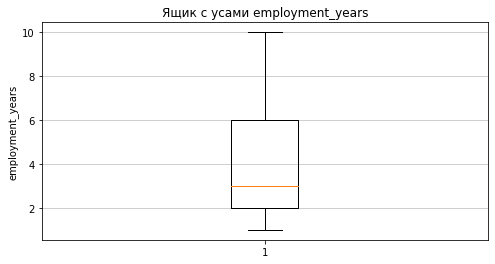

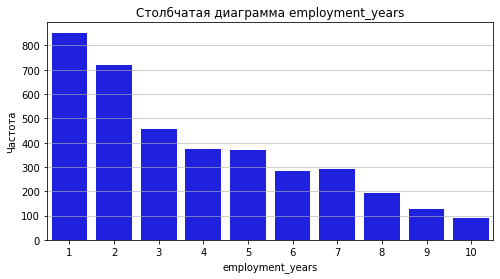

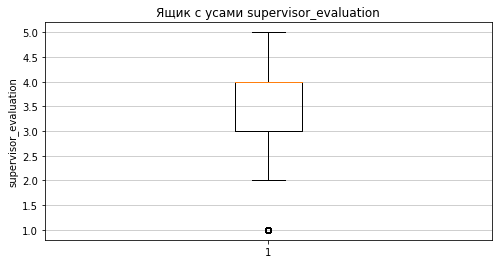

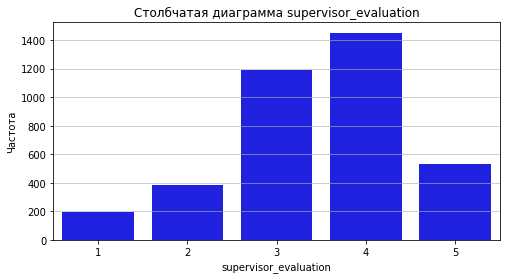

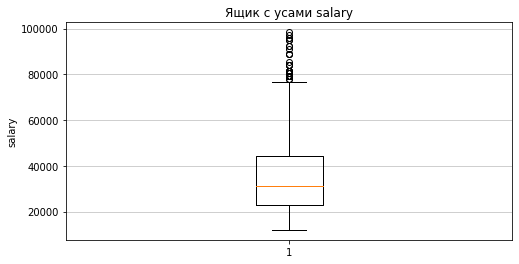

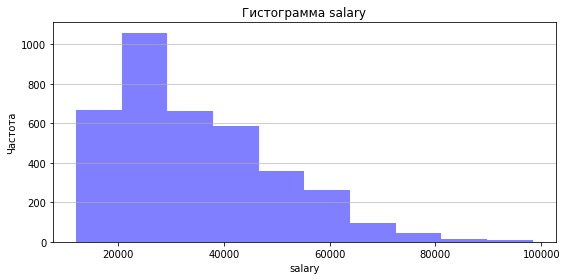

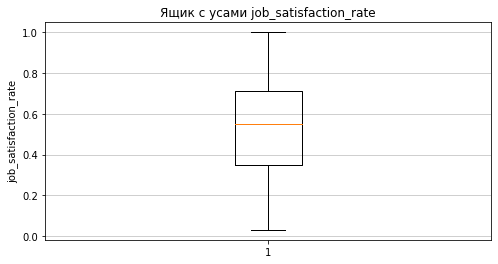

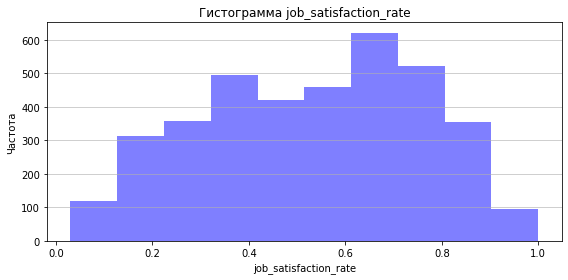

In [20]:
# визуализирую количественные признаки df_train_job_satisfaction_rate
plot_numeric_features(df_train_job_satisfaction_rate)

- Половина всех сотрудников работают не более трех лет.
- В основном сотрудники работают на 4 из 5, по оценке их руководителей
- Зарплата половины сотрудников не превышает 31200
- На гистограмме распределения признака удовлетворенности работой в компании 2 пика: 40% и 70% , среднее медианное значение - 53%.

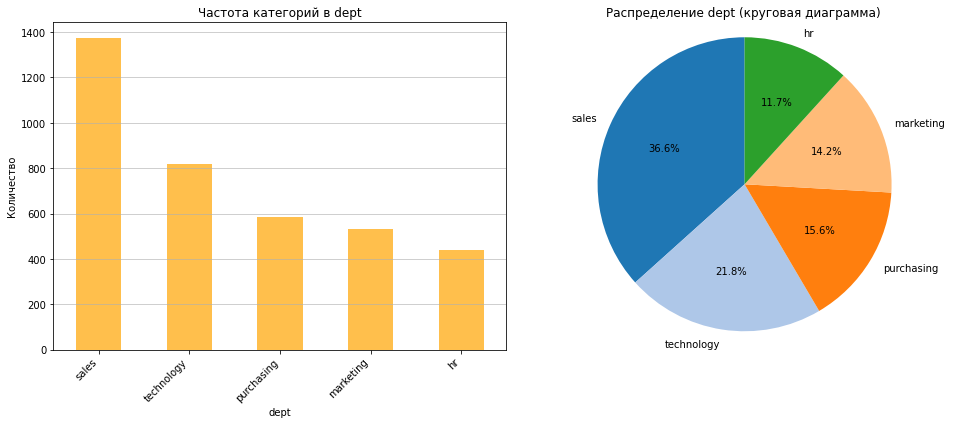

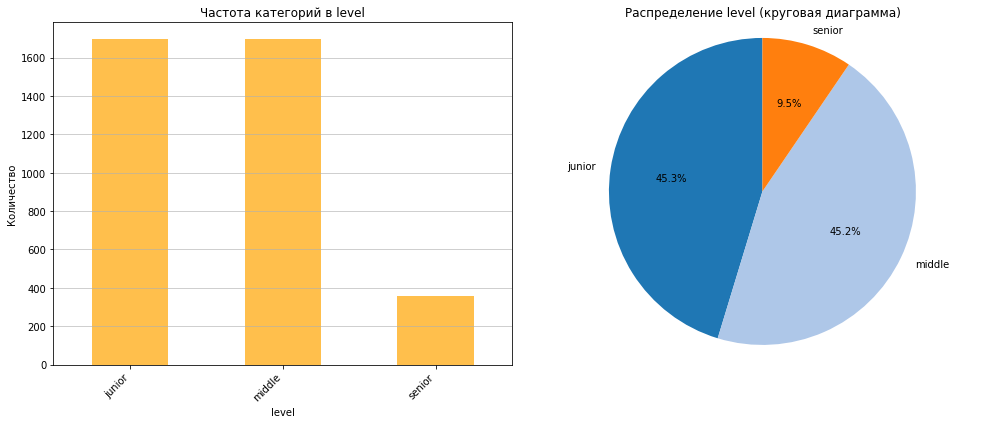

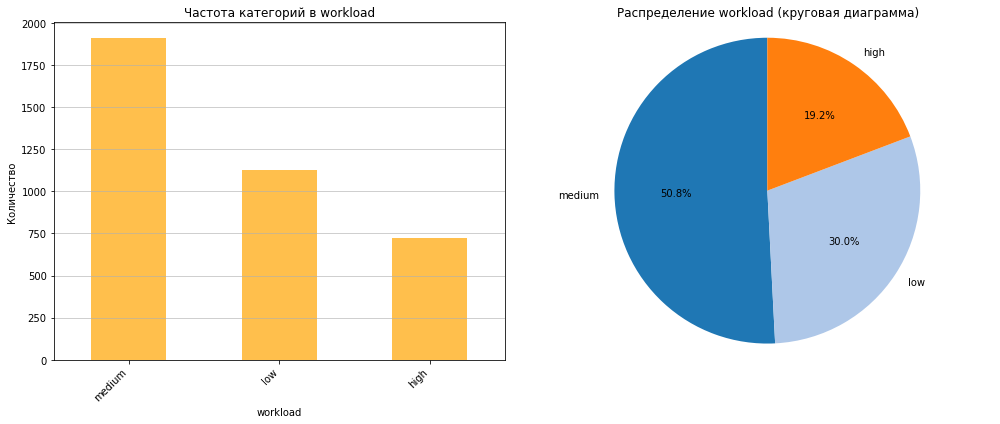

<Figure size 1008x432 with 0 Axes>

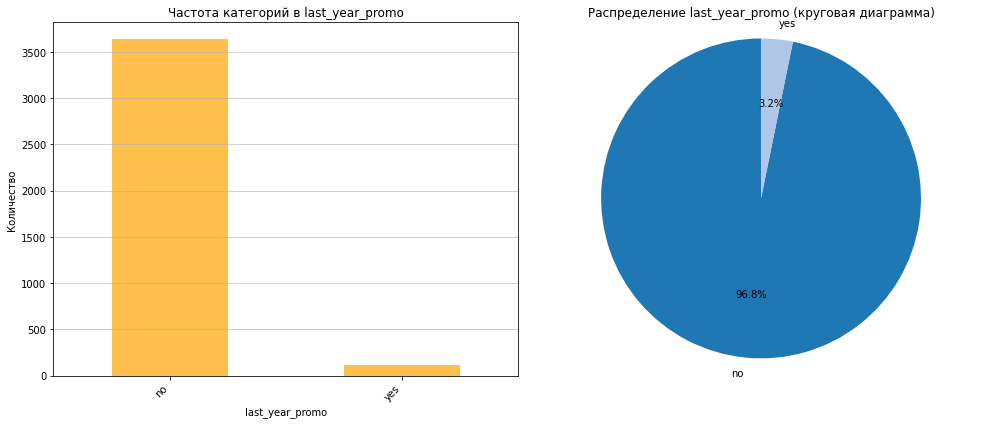

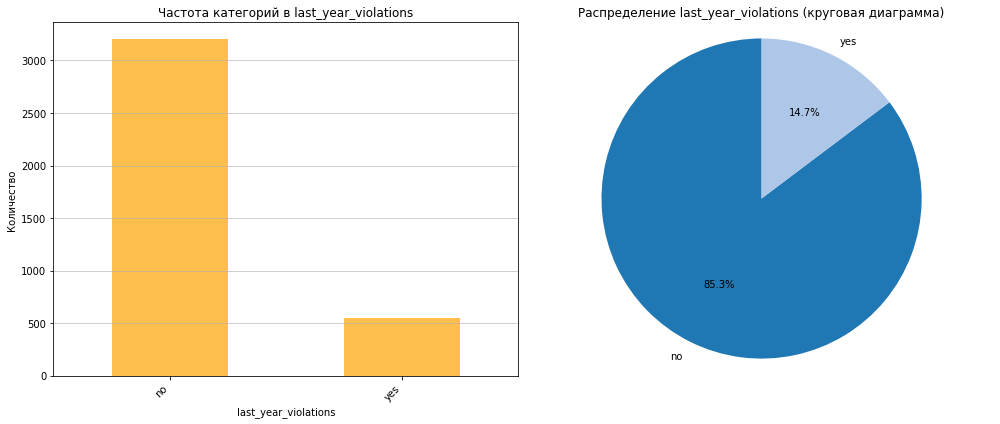

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

In [21]:
# визуализирую категориальные признаки df_train_job_satisfaction_rate
plot_categorical_features(df_train_job_satisfaction_rate)

- По 45% сотрудников работают на позициях junior и middle
- Всего 3% сотрудников получили повышение в прошлом году

**Корреляционный анализ**

In [22]:
interval_columns = [  
    'salary', 
    'job_satisfaction_rate'
]

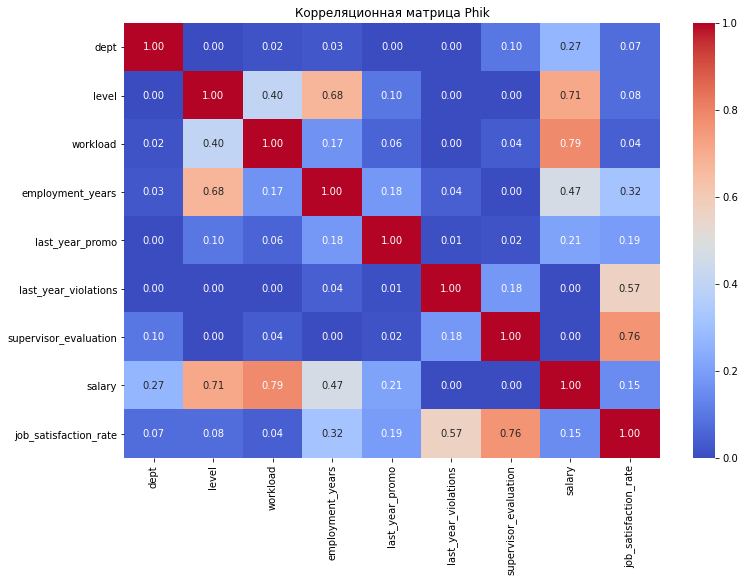

In [23]:
# вычисление матрицы корреляции с методом Phik
phik_matrix_result = df_train_job_satisfaction_rate.phik_matrix(interval_cols=interval_columns)

# визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix_result, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10})
plt.title('Корреляционная матрица Phik')
plt.show()

Целевой признак средне кореллирует только с оценкой руководителя. Среди остальных признаков наблюдается корелляция между между зарплатой и загруженностью. а также между зарплатой и занимаемой должностью. А занимамая должность кореллирует с длительностью работы в компании.

Все эти коэффициенты корелляции меньше 0.9, поэтому нет необходимости удалять какие-то из них.

Проверяю тоже самое для тестовой выбоки, чтобы убедиться, что в данных нет существенных различий

In [24]:
df_test_job_satisfaction_rate = pd.merge(df_test_target_job_satisfaction_rate, df_test_features, on = 'id', how = 'outer')
display(df_test_job_satisfaction_rate.head())

,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,,
100298,0.80,hr,junior,low,2,no,no,4,19200.0
100480,0.84,marketing,junior,low,4,no,no,4,16800.0
100503,0.79,purchasing,middle,high,5,no,no,4,55200.0
100610,0.75,sales,middle,medium,5,no,no,4,43200.0
100692,0.69,sales,middle,high,6,no,no,4,48000.0


In [25]:
display(df_test_job_satisfaction_rate.describe())

,job_satisfaction_rate,employment_years,supervisor_evaluation,salary
count,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.54878,3.666500,3.526500,34066.800000
std,0.22011,2.537222,0.996892,15398.436729
min,0.03000,1.000000,1.000000,12000.000000
25%,0.38000,1.000000,3.000000,22800.000000
50%,0.58000,3.000000,4.000000,30000.000000
75%,0.72000,6.000000,4.000000,43200.000000
max,1.00000,10.000000,5.000000,96000.000000


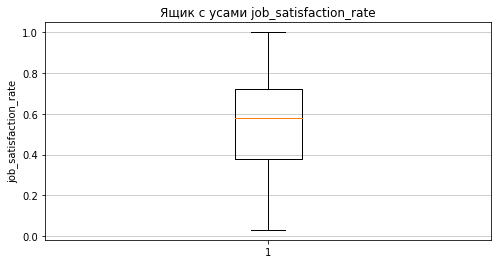

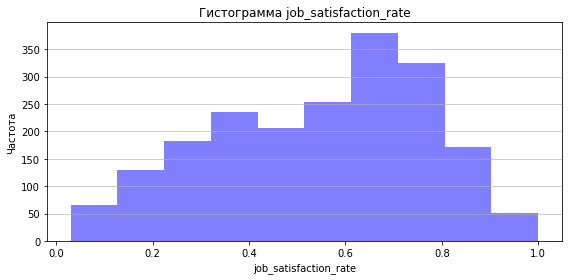

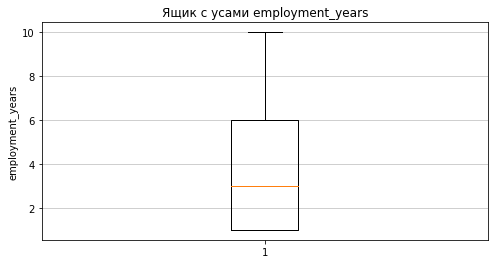

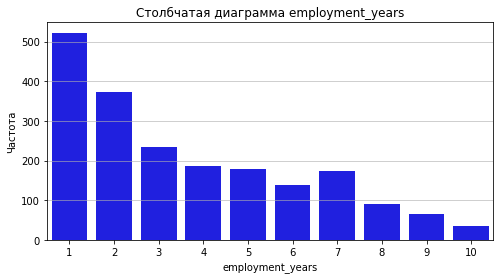

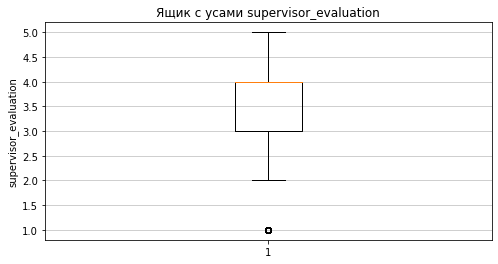

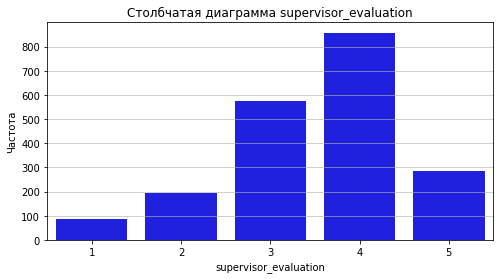

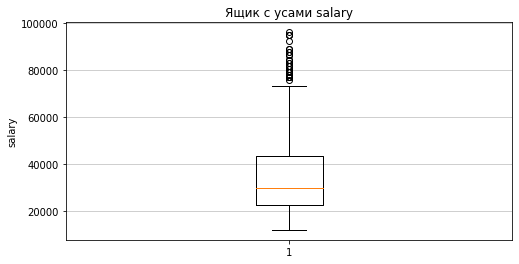

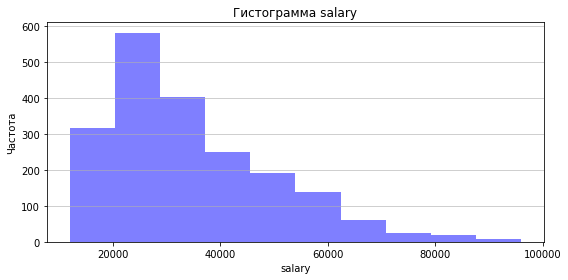

In [26]:
# визуализирую количественные признаки df_test_features
plot_numeric_features(df_test_job_satisfaction_rate)

<Figure size 1008x432 with 0 Axes>

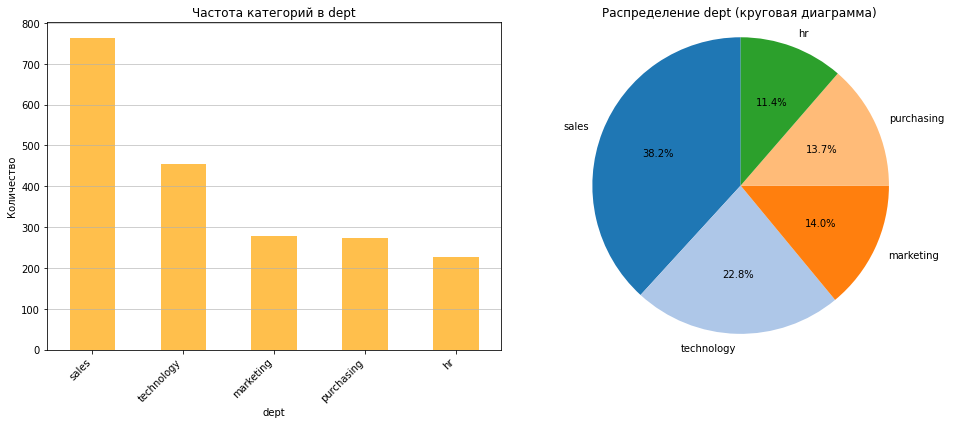

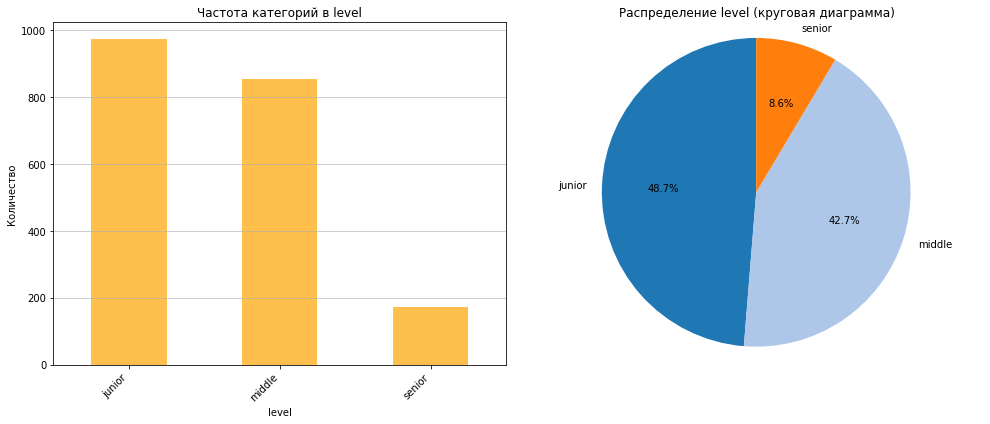

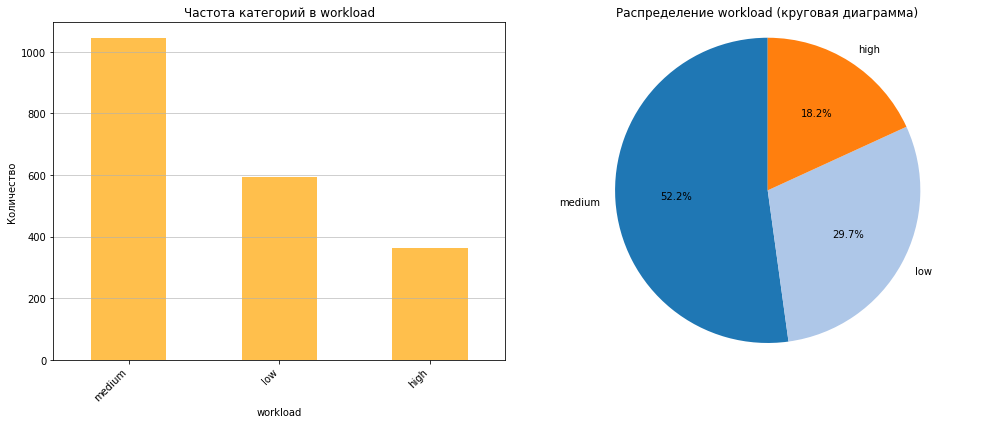

<Figure size 1008x432 with 0 Axes>

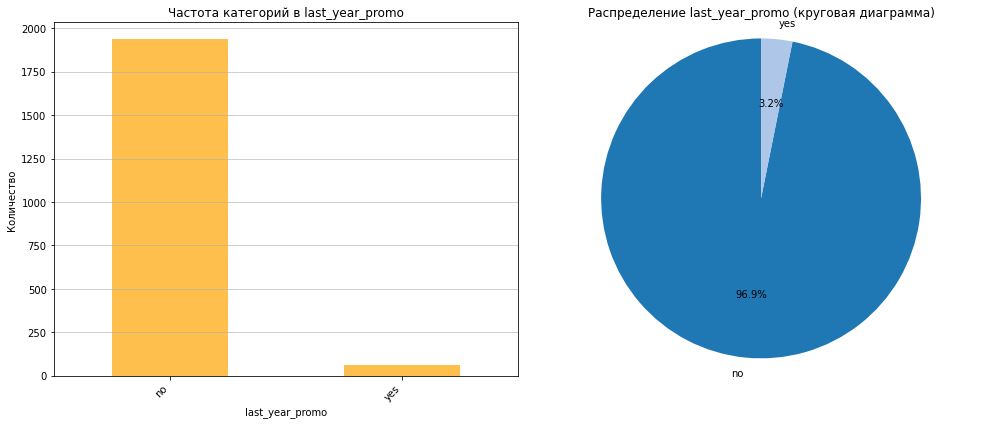

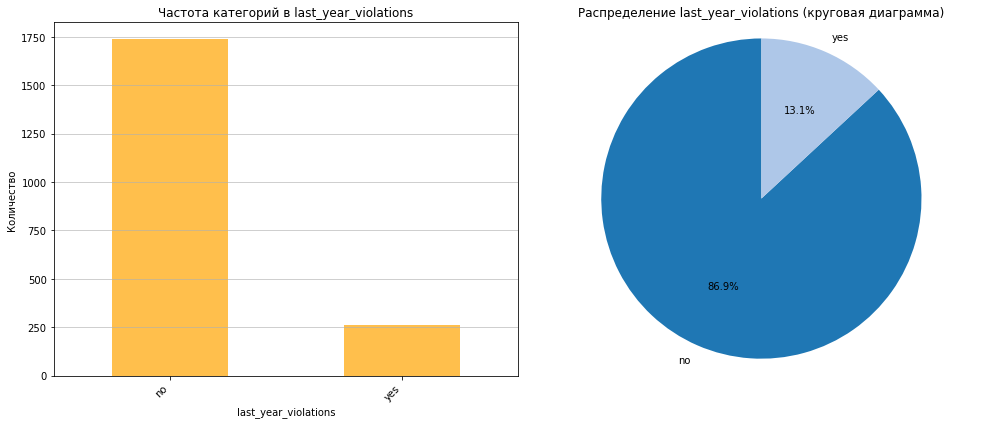

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

In [27]:
# визуализирую категориальные признаки df_test_features
plot_categorical_features(df_test_job_satisfaction_rate)

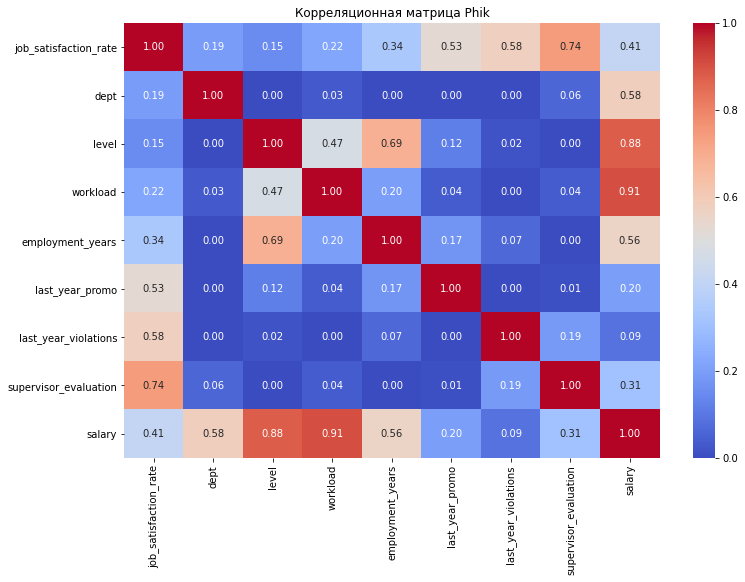

In [28]:
# вычисление матрицы корреляции с методом Phik
phik_matrix_result = df_test_job_satisfaction_rate.phik_matrix(interval_cols='salary')

# визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix_result, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10})
plt.title('Корреляционная матрица Phik')
plt.show()

При исследовательском анализе тестовые данные дают схожую с тренировочными картину. Однако видна более сильная корелляция между зарплатой и занимаемой должностью и зарплатой и загруженностью. Пока не буду удалять признаки, но запомню этот факт

**Вывод:**
1. Половина всех сотрудников работают не более трех лет.
2. В основном сотрудники работают на 4 из 5, по оценке их руководителей
3. Зарплата половины сотрудников не превышает 31200
4. На гистограмме распределения признака удовлетворенности работой в компании 2 пика: 40% и 70% , среднее медианное значение - 53%.
5. По 45% сотрудников работают на позициях junior и middle
6. Всего 3% сотрудников получили повышение в прошлом году
7. Целевой признак средне кореллирует только с оценкой руководителя. Среди остальных признаков наблюдается корелляция между между зарплатой и загруженностью. а также между зарплатой и занимаемой должностью. А занимамая должность кореллирует с длительностью работы в компании.Все эти коэффициенты корелляции меньше 0.9, поэтому нет необходимости удалять какие-то из них.
8. Тестовые данные показывают сходную с тернировочными картину.


## Подготовка данных

Разделю данные на тренировочную и тестовую выборки

In [29]:
X_train = df_train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = df_train_job_satisfaction_rate['job_satisfaction_rate']

X_test = df_test_features
y_test = df_test_target_job_satisfaction_rate['job_satisfaction_rate']

Начинаю собирать пайплайн:

In [30]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary']

Создаю пайплайн для подготовки признаков из списка ohe_columns. Если в данных есть пропуски, заполняю их самым часто встречающимся значением с помощью SimpleImputer. 

In [31]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ]
)

Cоздаю пайплайн для подготовки признаков из списка ord_columns. Заполняю пропуски в столбце 'level' самым часто встречающимся значением с помощью SimpleImputer. Поскольку пропуски относятся к сотрудникам с низким уровнем зарплаты, можно предположить, что они занимаются должностью junior, что является наиболее распространенным значением. Таким образом, заполнение пропусков значением most_frequent будет корректным

In [32]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [
                             ['junior', 'middle', 'senior'],
                             ['low', 'medium', 'high']
                            ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Создаю общий пайплайн для подготовки данных

In [33]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

**Выводы**:

Объединила этапы подготовки данных, применяя пайплайны ohe_pipe и ord_pipe. В соответствии с условиями задачи использовала два кодировщика.

## Обучение моделей

In [34]:
RANDOM_STATE = 42

In [35]:
# создаю итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [36]:
param = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(criterion = 'friedman_mse', random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15), 
        'models__max_features': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
     # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    }
]

Создаю функцию для расчета метрики SMAPE

In [37]:
def smape(y_test, y_pred):
    numerator = np.abs(y_pred - y_test)
    denominator = (np.abs(y_test)+np.abs(y_pred))/2
    smape_value = np.mean(numerator/denominator)*100
    return smape_value
    
smape_metrics = make_scorer(smape, greater_is_better = False)

Автоматический подбор с помощью RandomizedSearchCV:

In [38]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param, 
    scoring = smape_metrics,
    error_score= 'raise',
    n_iter=50,
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline...
                                         'models__min_samples_leaf': range(2, 15),
                                         'models__min_samples_split': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [39]:
print('Метрика smape для лучшей модели:\n', -randomized_search.best_score_)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика smape для лучшей модели:
 15.586201567975076
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImp

In [40]:
y_test_pred = randomized_search.predict(X_test)
print('Метрика smape на тестовой выборке:', smape(y_test, y_test_pred))

Метрика smape на тестовой выборке: 14.010773509343476


In [41]:
# создаю константную модель
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)  # подгоняю модель на тренировочных данных

# делаю предсказания на тестовой выборке
dummy_pred = dummy_model.predict(X_test)

# оценка модели
dummy_smape = smape(y_test, dummy_pred)

print('Метрика smape для DummyRegressor:', dummy_smape)

# Сравниваем результаты
if smape(y_test, y_test_pred) > dummy_smape:
    print('Лучшая модель не показывает улучшения по сравнению с DummyRegressor. Возможно, стоит пересмотреть подход.')
else:
    print('Лучшая модель значительно превосходит DummyRegressor по метрике smape.')

Метрика smape для DummyRegressor: 38.26225790202237
Лучшая модель значительно превосходит DummyRegressor по метрике smape.


# **Вывод:**

Обучено две модели: дерево решений и линейную регрессию, с применением методов масштабирования для настройки их гиперпараметров. Для автоматического подбора оптимальных гиперпараметров использован RandomizedSearchCV.

Чтобы оценить производительность модели, была введена метрика SMAPE. В результате подбора мы определили, что лучшей моделью является DecisionTreeRegressor, который имел следующие параметры: criterion='friedman_mse', max_depth=14, max_features=9, min_samples_leaf=3 и min_samples_split=9. Значение метрики SMAPE на тестовой выборке составило 14,01%. Лучшая модель значительно превосходит константную модель (DummyRegressor) по метрике smape.

## Выводы
Первой задачей этого проекта была разработка модели, способной предсказывать уровень удовлетворённости сотрудников на основе предоставленных заказчиком данных.

в ходе работы были выполнены следующие этапы:
1. Анализ информации о данных:
- В данных df_train_job_satisfaction_rate 4000 строк. Обнаружены пропуски. Типы столбцов указаны верно. Название столбцов корректны
- В данных df_test_features 2000 строк. Обнаружены пропуски. Типы столбцов указаны верно. Название столбцов корректны
- В df_test_target_job_satisfaction_rate 2000 строк. Пропусков нет. Типы столбцов указаны верно. Названия столбцов корректны.
2. Предобработка данных:
- Во всех таблицах индексы заменены на id
- В столбцах в dept и workload значения ' ' заменены на NaN,  sinior на senior
- Тип данных в столбце salary изменен на float64
- В df_train_job_satisfaction_rate удалены явные дубликаты
3. Исследовательский анализ данных:
- Половина всех сотрудников работают не более трех лет.
- В основном сотрудники работают на 4 из 5, по оценке их руководителей
- Зарплата половины сотрудников не превышает 31200
- На гистограмме распределения признака удовлетворенности работой в компании 2 пика: 40% и 70% , среднее медианное значение - 53%.
- По 45% сотрудников работают на позициях junior и middle
- Всего 3% сотрудников получили повышение в прошлом году
- Целевой признак средне кореллирует только с оценкой руководителя. Среди остальных признаков наблюдается корелляция между между зарплатой и загруженностью. а также между зарплатой и занимаемой должностью. А занимамая должность кореллирует с длительностью работы в компании.Все эти коэффициенты корелляции меньше 0.9, поэтому нет необходимости удалять какие-то из них.
- Тестовые данные показывают сходную с тернировочными картину.
4. Подготовка данных:
- Объединtys этапы подготовки данных, применяя пайплайны ohe_pipe и ord_pipe. В соответствии с условиями задачи использоваys два кодировщика.
5. Обучение модели:
- Обучено две модели: дерево решений и линейную регрессию, с применением методов масштабирования для настройки их гиперпараметров. Для автоматического подбора оптимальных гиперпараметров использован RandomizedSearchCV.

- Чтобы оценить производительность модели, была введена метрика SMAPE. В результате подбора мы определили, что лучшей моделью является DecisionTreeRegressor, который имел следующие параметры: criterion='friedman_mse', max_depth=14, max_features=9, min_samples_leaf=3 и min_samples_split=9. Значение метрики SMAPE на тестовой выборке составило 14,09%. Значение метрики SMAPE на тестовой выборке составило 14,09%.

# Задача 2: предсказание увольнения сотрудника из компании

## Загрузка данных

In [42]:
df_train_quit = pd.read_csv('/datasets/train_quit.csv') #тренировочная выборка
df_test_target_quit = pd.read_csv('/datasets/test_target_quit.csv') #целевой признак тестовой выборки

In [43]:
open_df(df_train_quit, df_name="df_train_quit")

Анализ df_train_quit:

Общая информация о df_train_quit:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None


Первые строки df_train_quit:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



Статистики для df_train_quit:


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


В данных df_train_quit 4000 строк. Пропусков не обнаружено. Типы столбцов указаны верно. Названия столбцов корректны.

In [44]:
open_df(df_test_target_quit, df_name="df_test_target_quit")

Анализ df_test_target_quit:

Общая информация о df_test_target_quit:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None


Первые строки df_test_target_quit:


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



Статистики для df_test_target_quit:


,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


В данных df_test_target_quit 2000 строк. Пропусков не обнаружено. Типы столбцов указаны верно. Названия столбцов корректны.

**Выводы:**

- В данных df_train_quit 4000 строк. Пропусков не обнаружено. Типы столбцов указаны верно. Названия столбцов корректны
- В данных df_test_target_quit 2000 строк. Пропусков не обнаружено. Типы столбцов указаны верно. Названия столбцов корректны.

## Предобработка данных

**Замена индексов на id**

In [45]:
df_train_quit = df_train_quit.set_index('id')
display(df_train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [46]:
df_test_target_quit = df_test_target_quit.set_index('id')
display(df_test_target_quit.head())

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


Приведу к одинаковому порядку строки в таблицах с целевым и входными признаками

In [47]:
df_test_features = df_test_features.sort_values(by = 'id')
df_test_target_quit = df_test_target_quit.sort_values(by = 'id')
display(df_test_features.head())
display(df_test_target_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200.0
100480,marketing,junior,low,4,no,no,4,16800.0
100503,purchasing,middle,high,5,no,no,4,55200.0
100610,sales,middle,medium,5,no,no,4,43200.0
100692,sales,middle,high,6,no,no,4,48000.0


,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


**Анализ уникальных наименований**

In [48]:
print(f'Уникальные значения для отдела:{df_train_quit["dept"].unique()}')
print(f'Уникальные значения для уровня занимаемой должности:{df_train_quit["level"].unique()}')
print(f'Уникальные значения для уровня загруженности:{df_train_quit["workload"].unique()}')
print(f'Уникальные значения для повышений:{df_train_quit["last_year_promo"].unique()}')
print(f'Уникальные значения для нарушений:{df_train_quit["last_year_violations"].unique()}')

Уникальные значения для отдела:['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для уровня занимаемой должности:['middle' 'junior' 'sinior']
Уникальные значения для уровня загруженности:['high' 'medium' 'low']
Уникальные значения для повышений:['no' 'yes']
Уникальные значения для нарушений:['no' 'yes']


In [49]:
df_train_quit["level"] =df_train_quit["level"].replace('sinior', 'senior')
print(f'Уникальные значения для уровня занимаемой должности:{df_train_quit["level"].unique()}')

Уникальные значения для уровня занимаемой должности:['middle' 'junior' 'senior']


Заменила 'sinior' на 'senior'

**Изменение типов данных**

Изменю тип данных для salary

In [50]:
df_train_quit['salary'] = df_train_quit['salary'].astype(float)
print(df_train_quit['salary'].dtype)

float64


**Поиск дубликатов**

In [51]:
#исследую данные на наличие явных дубликатов
print('Количество явных дубликатов в "df_train_quit" = ', df_train_quit.duplicated().sum())

Количество явных дубликатов в "df_train_quit" =  1413


Дубликаты могут портить качество модели, поэтому удалю их

In [52]:
df_train_quit = df_train_quit.drop_duplicates()
print('Количество явных дубликатов в "df_train_quit" = ',df_train_quit.duplicated().sum())

Количество явных дубликатов в "df_train_quit" =  0


**Вывод**

В ходе предобработки данных в датафреймах сделаны следующие преобразования:
1. Во всех таблицах индексы заменены на id
2. В столбце 'level' значение 'sinior' заменено на 'senior'
3. Тип данных в столбце salary изменен на float64
4. В df_train_quit удалены явные дубликаты

## Исследовательский анализ данных

In [53]:
display(df_train_quit.describe())

,employment_years,supervisor_evaluation,salary
count,2587.000000,2587.000000,2587.000000
mean,4.213375,3.367994,37107.692308
std,2.601105,1.080243,16267.354906
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,24000.000000
50%,4.000000,3.000000,33600.000000
75%,6.000000,4.000000,46800.000000
max,10.000000,5.000000,96000.000000


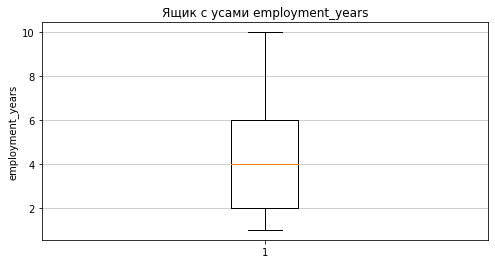

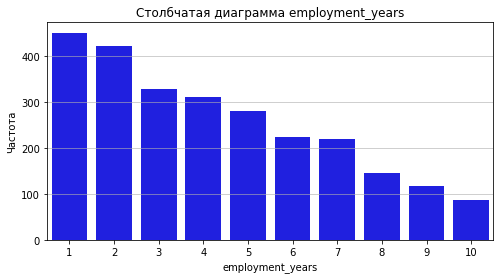

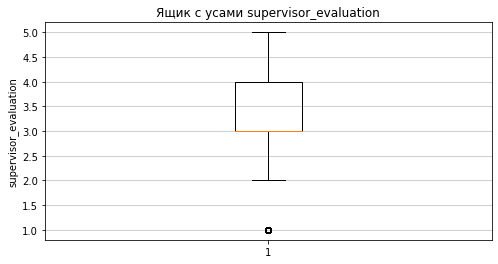

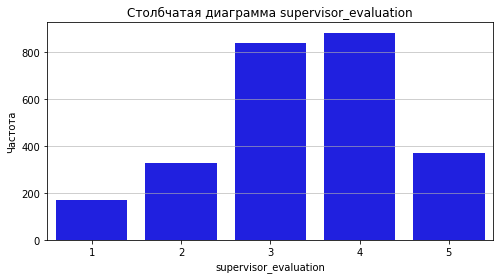

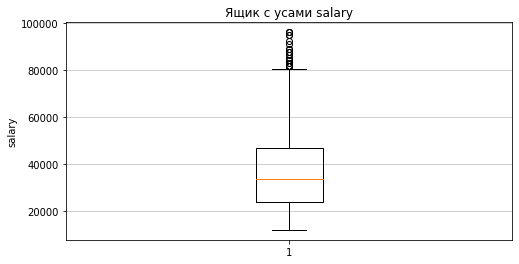

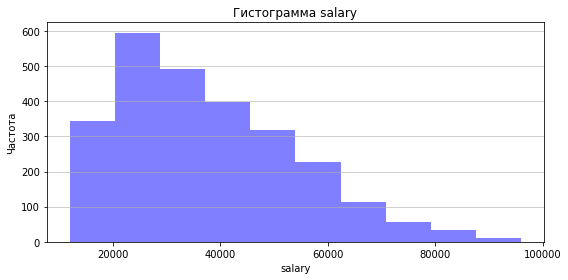

In [54]:
# визуализирую количественные признаки df_train_quit
plot_numeric_features(df_train_quit)

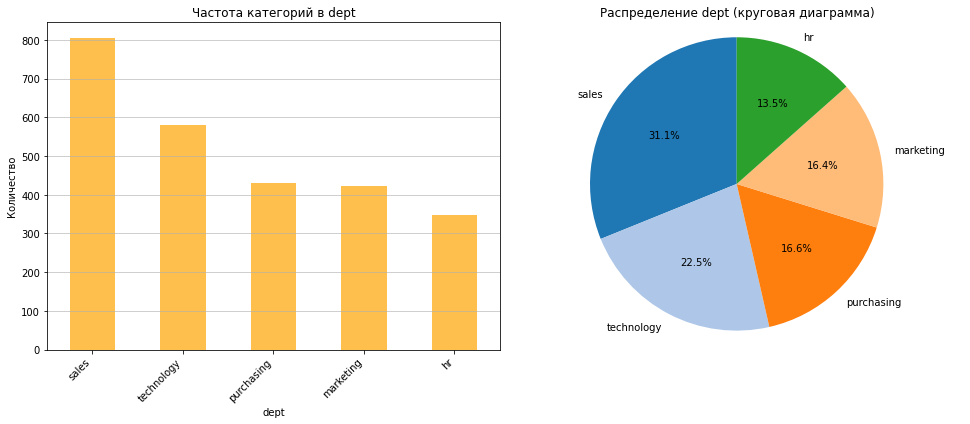

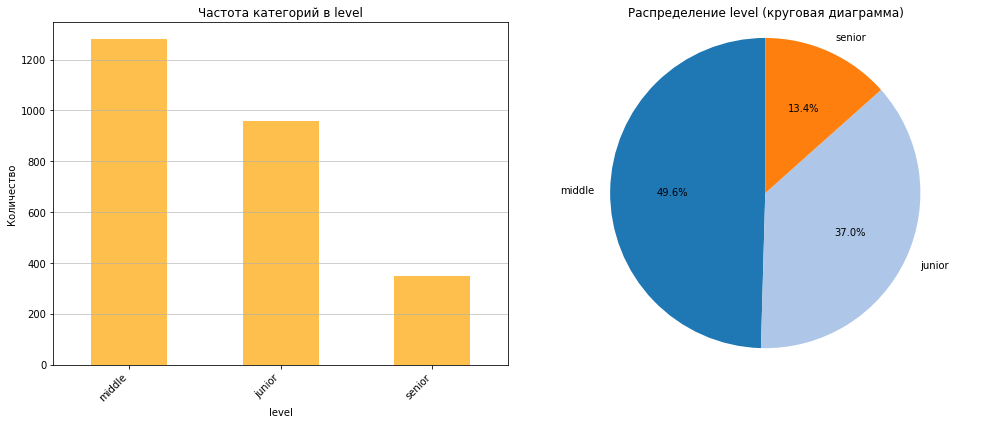

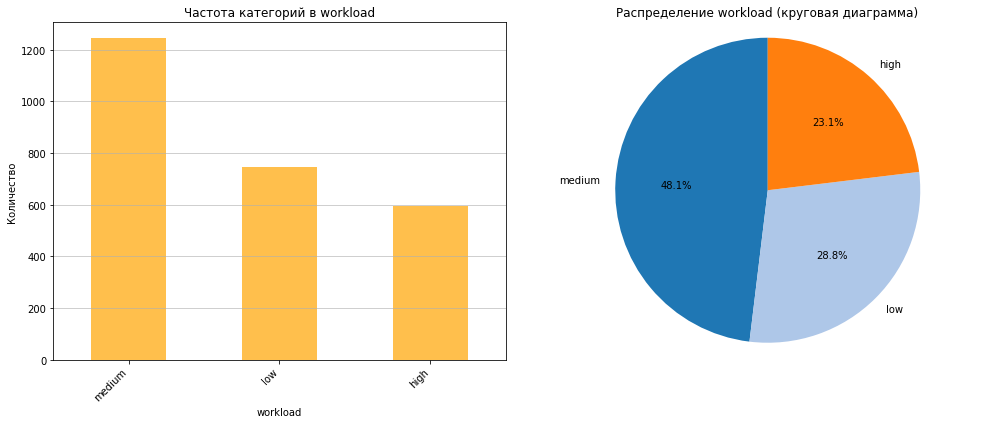

<Figure size 1008x432 with 0 Axes>

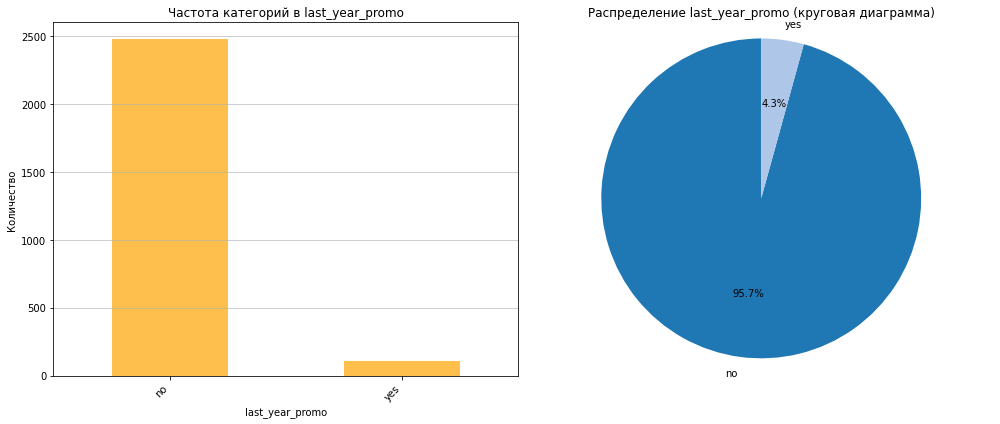

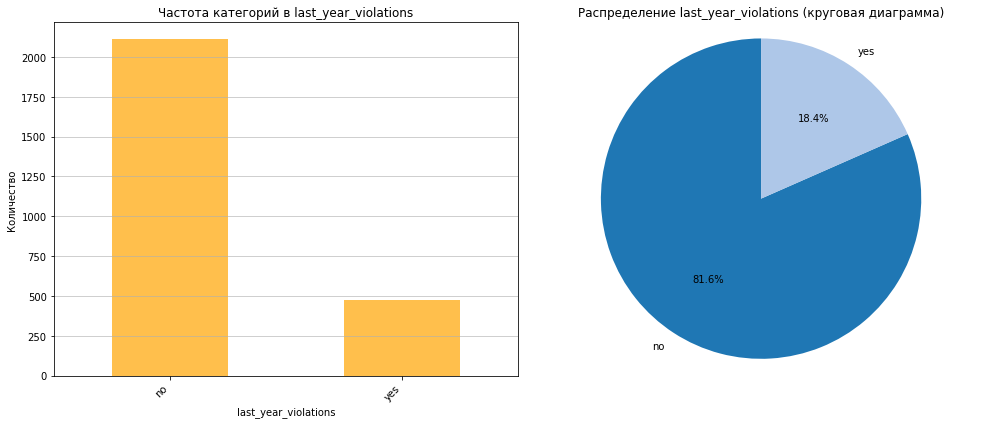

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

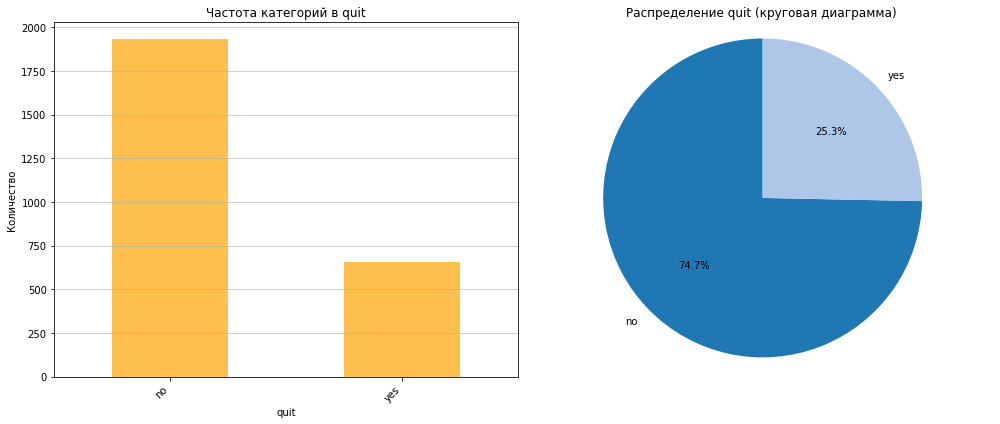

In [55]:
# визуализирую категориальные признаки df_train_quit
plot_categorical_features(df_train_quit)

Распределение количественных и качественных признаков соответствует таковому в предыдущей тренировочной выборке.
По признаку quit - 25.3% сотрудников уволились из компании

Составлю "портрет" уволившевогося сотрудника

In [56]:
def histogram_discrete(df, col, target):
    plt.figure(figsize=(8, 6))
    plot = sns.countplot(data=df, x=col, hue=target)
    plot.set_title(f'Распределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)
    plt.show()

def histogram_continuous(df, col, target):
    plt.figure(figsize=(8, 6))
    plot = sns.histplot(df, bins=20, x=col, hue=target, stat='density', common_norm=False)
    plot.set_title(f'Нормированная гистограмма для {col}', fontsize=16)
    plot.set_ylabel('Плотность', fontsize=14)
    plt.show()

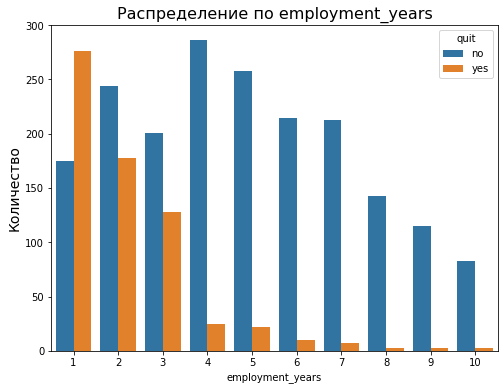

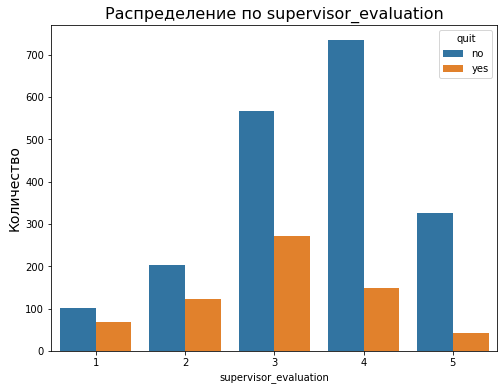

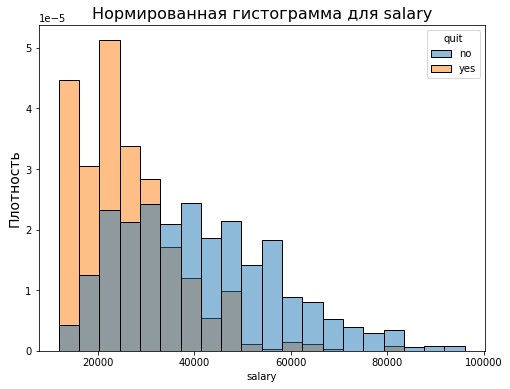

In [57]:
num_columns = list(df_train_quit.select_dtypes(include='number').columns)
target = 'quit'
df = df_train_quit

# итерация для анализа
for col in num_columns:
    if col in ['supervisor_evaluation', 'employment_years']:
        histogram_discrete(df, col, target)
    else:
        histogram_continuous(df, col, target)

In [58]:
display(df_train_quit[df_train_quit['quit'] == 'yes'].describe())

,employment_years,supervisor_evaluation,salary
count,655.000000,655.000000,655.000000
mean,2.161832,2.958779,25767.938931
std,1.497626,1.047705,10484.828614
min,1.000000,1.000000,12000.000000
25%,1.000000,2.000000,18000.000000
50%,2.000000,3.000000,24000.000000
75%,3.000000,4.000000,30600.000000
max,10.000000,5.000000,79200.000000


In [59]:
# получаю относительные величины для переменной 'quit'
quit_distribution = df_train_quit['quit'].value_counts(normalize=True)
print("Распределение по увольнению:")
display(quit_distribution)

Распределение по увольнению:


no     0.746811
yes    0.253189
Name: quit, dtype: float64

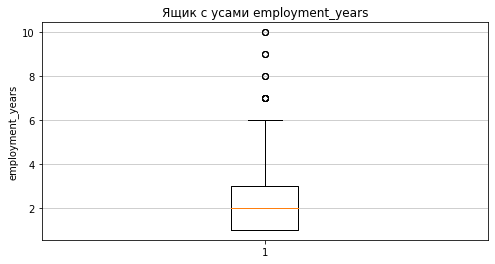

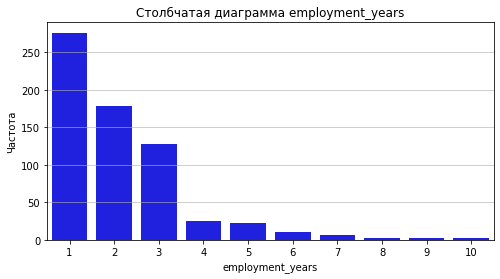

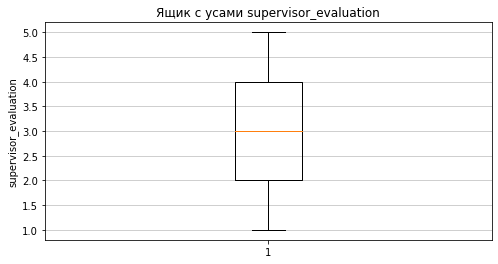

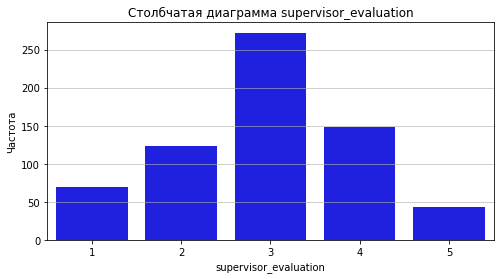

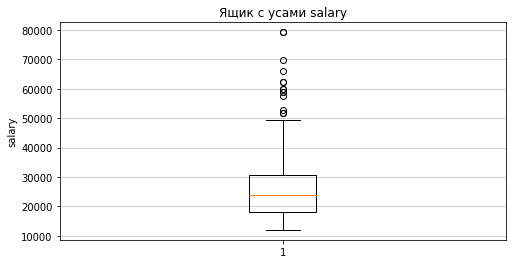

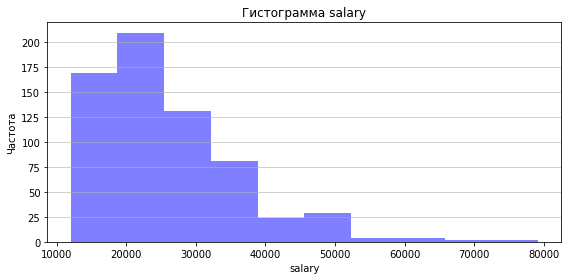

In [60]:
# визуализирую количественные признаки df_market_file для уволившихся
plot_numeric_features(df_train_quit[df_train_quit['quit'] == 'yes'])

75% уволенных сотрудников проработали в компании не более 3 лет и получали они не более 35000

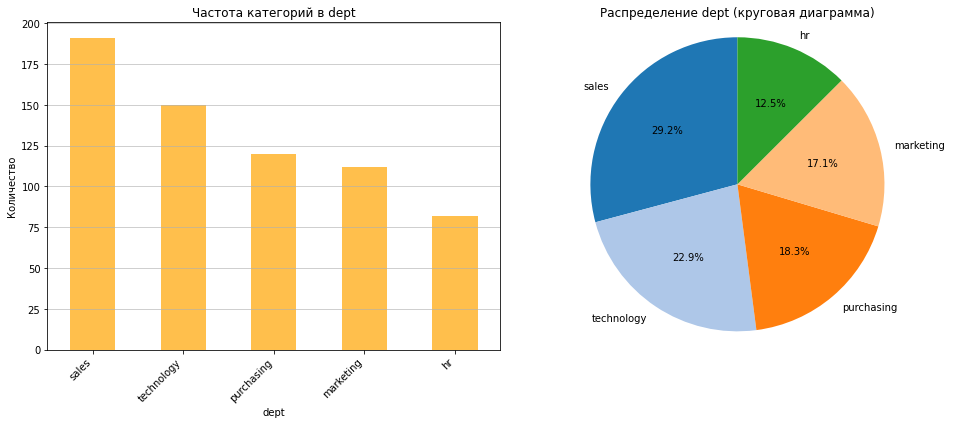

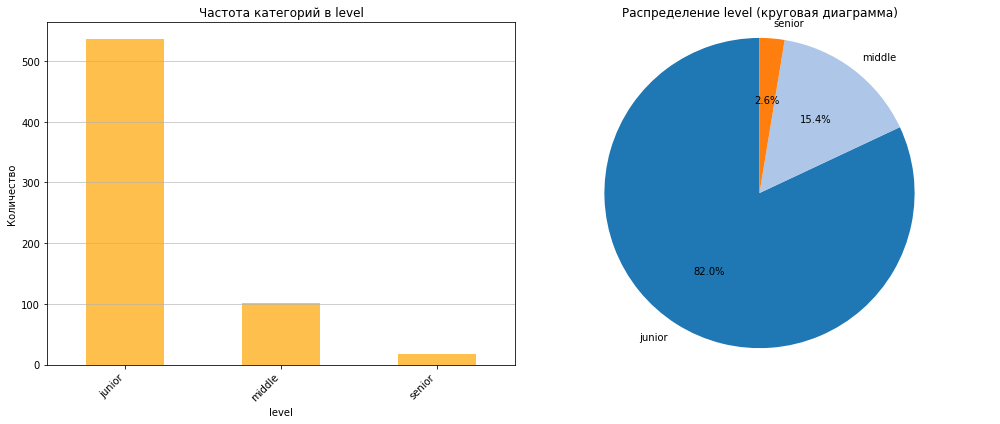

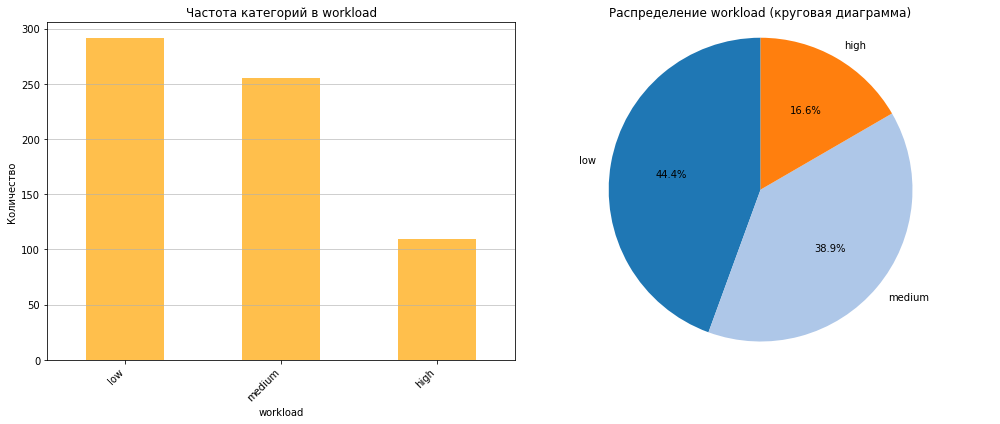

<Figure size 1008x432 with 0 Axes>

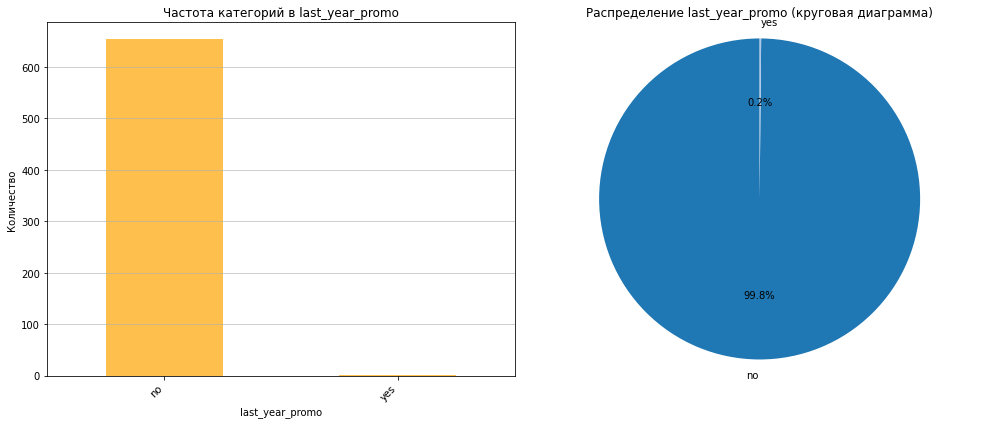

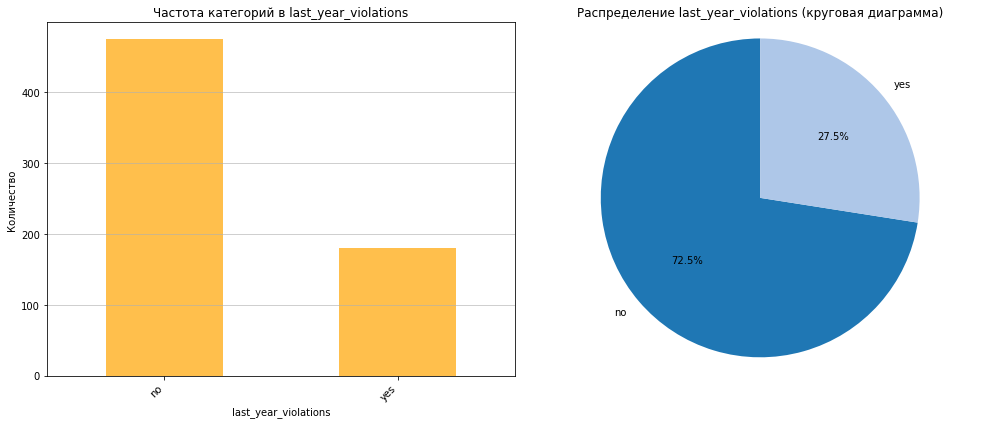

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

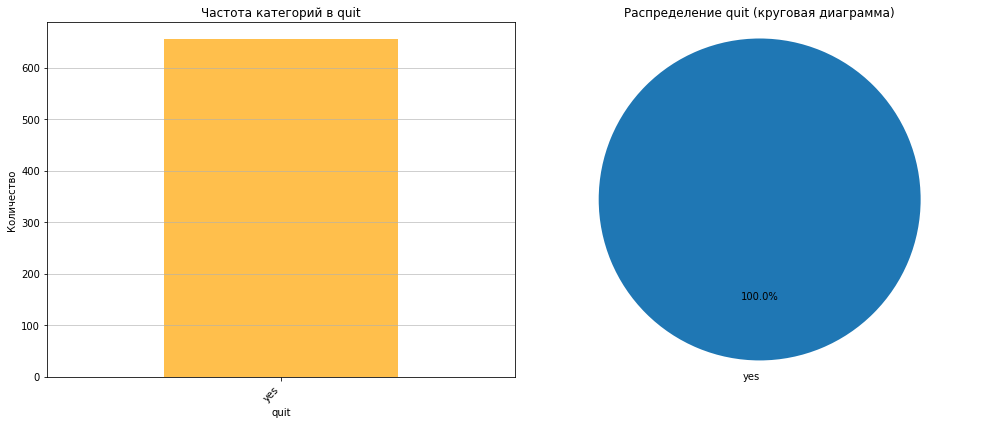

In [61]:
# визуализирую категориальные признаки df_train_quit для уволившихся
plot_categorical_features(df_train_quit[df_train_quit['quit'] == 'yes'])

Подавляющее большинство сотрудников работали на позиции junior. Процентное соотношение по оттоку кадров соответсвует их распределению в компании - из больших отделов sales и technology увольняется больше людей, чем из отделов по-меньше. Интересно, что преобладающее большинство (44,4%) уволившихся сотрудников имели низкую загруженность. 99,8% из них не получали повышения за последний год. Хотя в последнем случае имеет смысл учитывать, что большинство из них работали в компании непродолжительно

In [62]:
display(df_train_quit[df_train_quit['quit'] == 'no'].describe())

,employment_years,supervisor_evaluation,salary
count,1932.000000,1932.000000,1932.000000
mean,4.908903,3.506729,40952.173913
std,2.527730,1.055898,16085.739667
min,1.000000,1.000000,12000.000000
25%,3.000000,3.000000,27600.000000
50%,5.000000,4.000000,39000.000000
75%,7.000000,4.000000,51600.000000
max,10.000000,5.000000,96000.000000


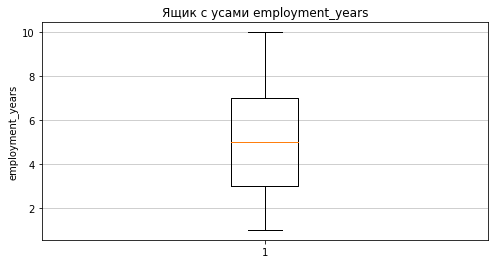

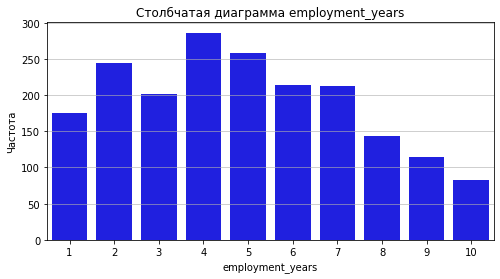

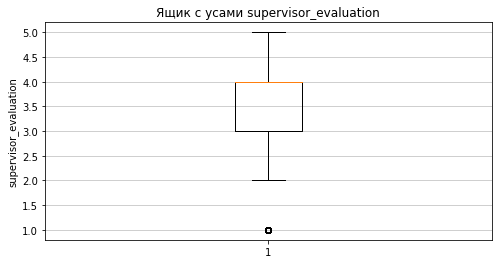

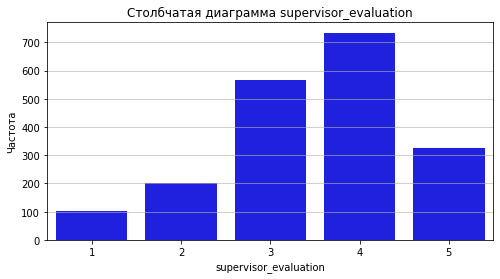

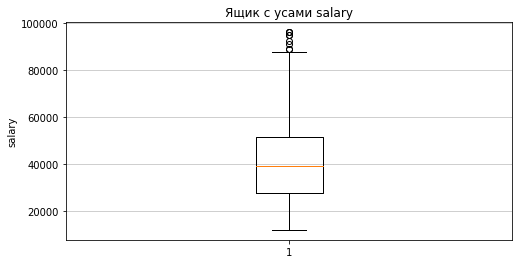

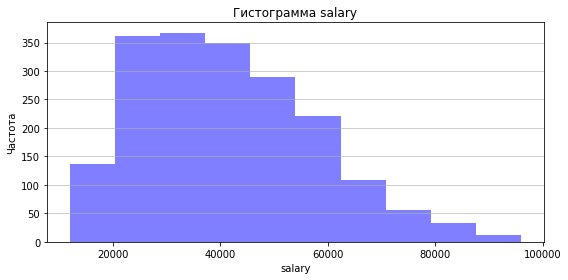

In [63]:
# визуализирую количественные признаки df_market_file для оставшихся
plot_numeric_features(df_train_quit[df_train_quit['quit'] == 'no'])

В среднем оставшиеся сотрудники работают в компании около 5 лет. И зарплата 75% сотрудников больше 27000

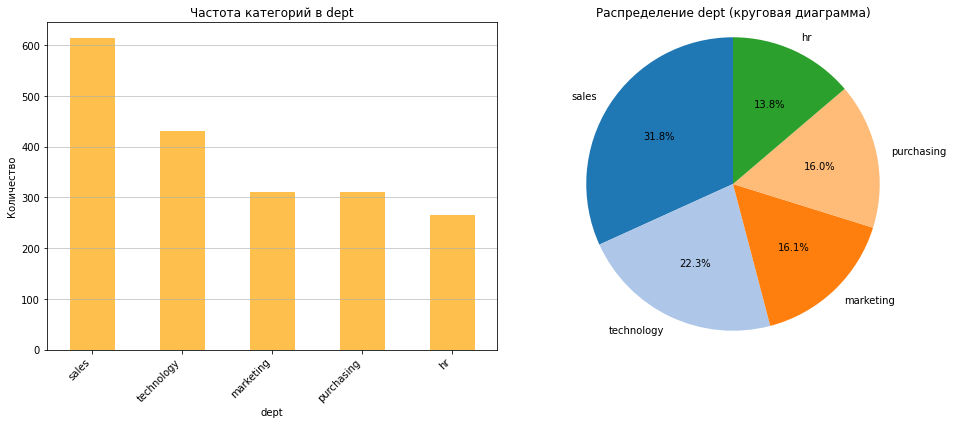

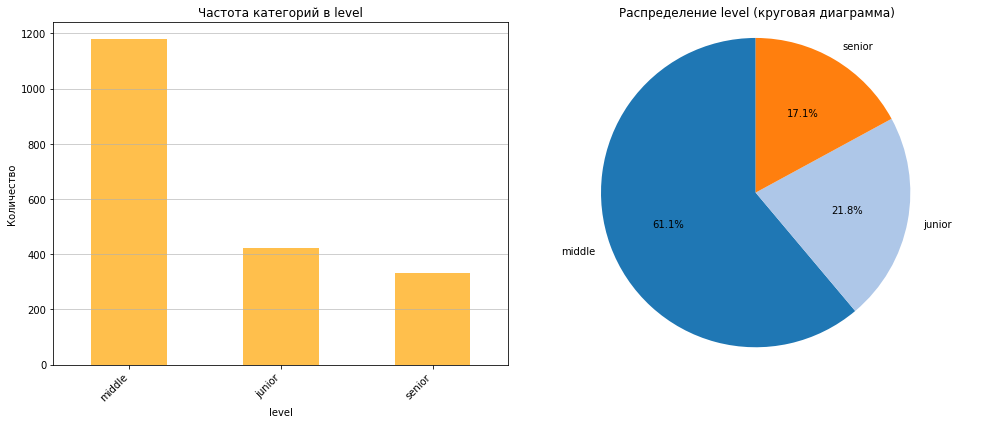

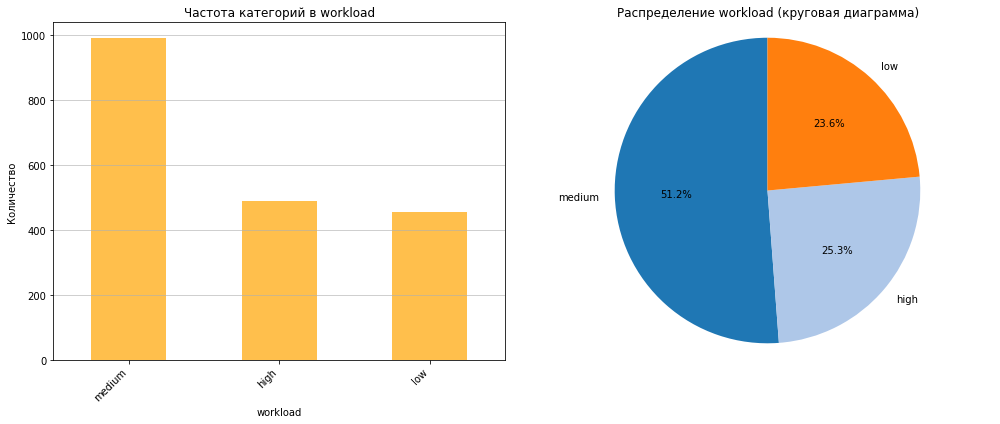

<Figure size 1008x432 with 0 Axes>

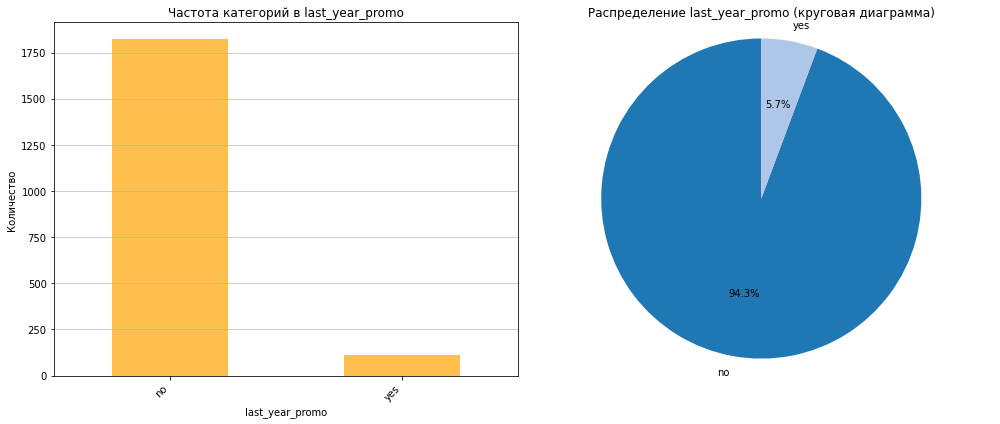

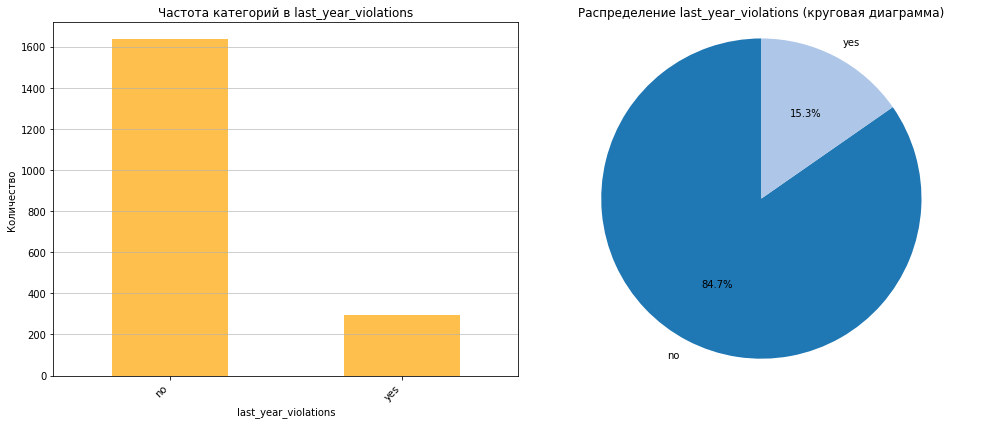

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

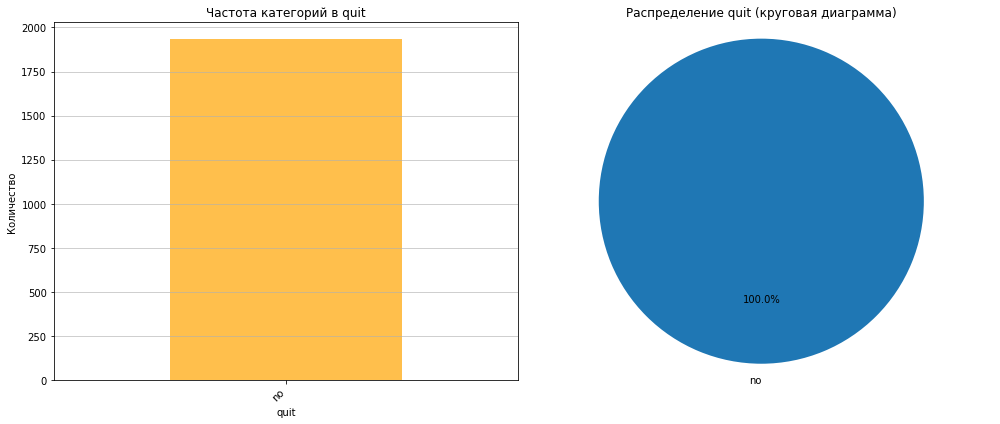

In [64]:
# визуализирую категориальные признаки df_train_quit для оставшихся
plot_categorical_features(df_train_quit[df_train_quit['quit'] == 'no'])

Подавляющее большнство оставшихся сотрудников (78.2%) работают на позициях middle и senior. Низкая загруженность среди оставшихся сотрудников толко у 23.6%. 5.7% из оставшихся получили повышение за последний год

In [65]:
distribution_list=['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations','supervisor_evaluation']

Распределение по признаку dept:


quit,no,yes
dept,,
hr,0.764368,0.235632
marketing,0.735225,0.264775
purchasing,0.720930,0.279070
sales,0.762733,0.237267
technology,0.741824,0.258176


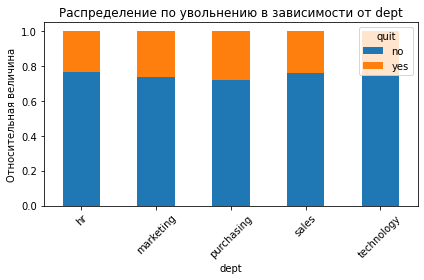

Распределение по признаку level:


quit,no,yes
level,,
junior,0.439457,0.560543
middle,0.921217,0.078783
senior,0.951009,0.048991


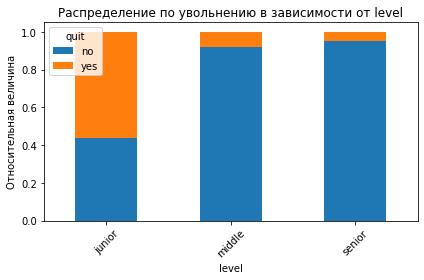

Распределение по признаку workload:


quit,no,yes
workload,,
high,0.817420,0.182580
low,0.609920,0.390080
medium,0.795016,0.204984


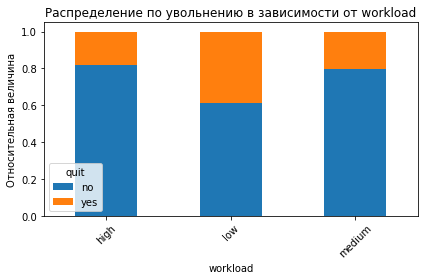

Распределение по признаку employment_years:


quit,no,yes
employment_years,,
1,0.388027,0.611973
2,0.578199,0.421801
3,0.610942,0.389058
4,0.919614,0.080386
5,0.921429,0.078571
6,0.955357,0.044643
7,0.968182,0.031818
8,0.979452,0.020548
9,0.974576,0.025424


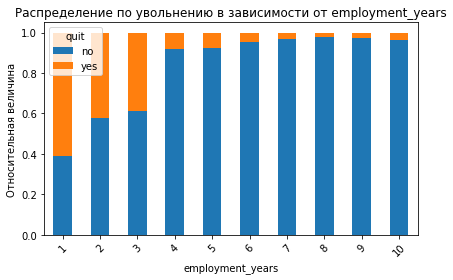

Распределение по признаку last_year_promo:


quit,no,yes
last_year_promo,,
no,0.735864,0.264136
yes,0.990991,0.009009


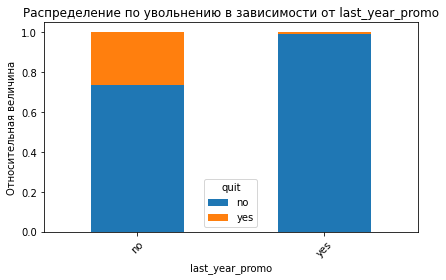

Распределение по признаку last_year_violations:


quit,no,yes
last_year_violations,,
no,0.774988,0.225012
yes,0.621849,0.378151


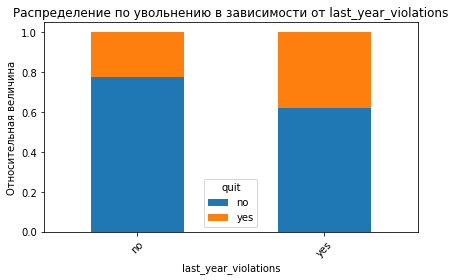

Распределение по признаку supervisor_evaluation:


quit,no,yes
supervisor_evaluation,,
1,0.596491,0.403509
2,0.622699,0.377301
3,0.675805,0.324195
4,0.832200,0.167800
5,0.883469,0.116531


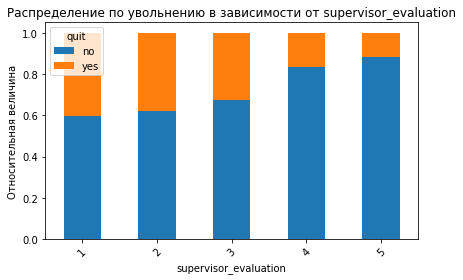

In [66]:
for feature in distribution_list:
    feature_distribution = df_train_quit.groupby(feature)['quit'].value_counts(normalize=True).unstack()
   
    print(f"Распределение по признаку {feature}:")
    display(feature_distribution)
    
    feature_distribution.plot(kind='bar', stacked=True)
    plt.title(f"Распределение по увольнению в зависимости от {feature}")
    plt.xlabel(feature)
    plt.ylabel("Относительная величина")
    plt.xticks(rotation=45)  
    
    plt.tight_layout()
    plt.show()

Для того чтобы сравнить распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников объединяю таблицы df_test_target_job_satisfaction_rate и df_test_target_quit

In [67]:
display(df_test_target_job_satisfaction_rate.head())
print(df_test_target_job_satisfaction_rate.shape)
display(df_test_target_quit.head())
print(df_test_target_quit.shape)

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


(2000, 1)


,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


(2000, 1)


In [68]:
df_test_target = pd.merge(df_test_target_job_satisfaction_rate, df_test_target_quit, on = 'id', how = 'outer')
display(df_test_target.head())
print(df_test_target.shape)

,job_satisfaction_rate,quit
id,,
100298,0.80,no
100480,0.84,no
100503,0.79,no
100610,0.75,no
100692,0.69,no


(2000, 2)


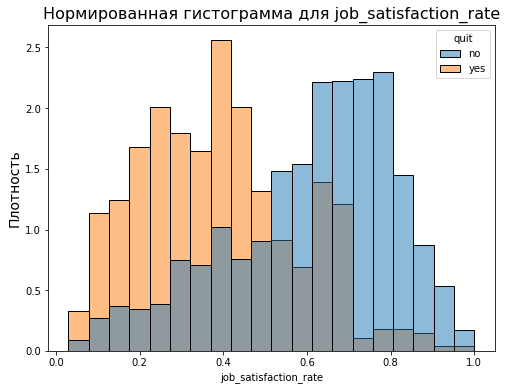

In [69]:
histogram_continuous(df_test_target, 'job_satisfaction_rate', 'quit')

Удовлетворенность работой для уволившихся

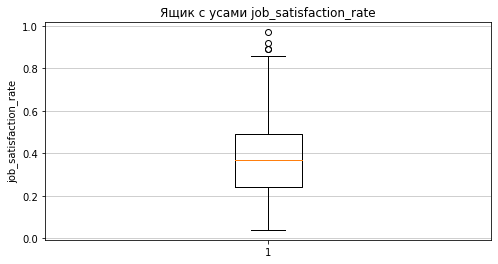

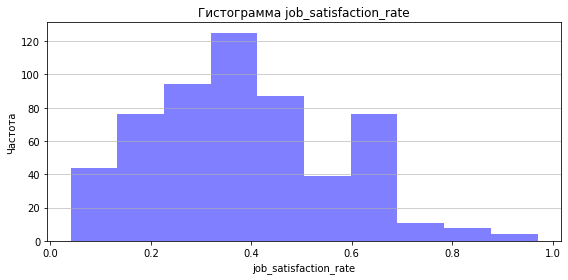

In [70]:
# визуализирую количественные признаки df_test_target
plot_numeric_features(df_test_target[df_test_target['quit'] == 'yes'])

Удовлетворенность работой для оставшихся

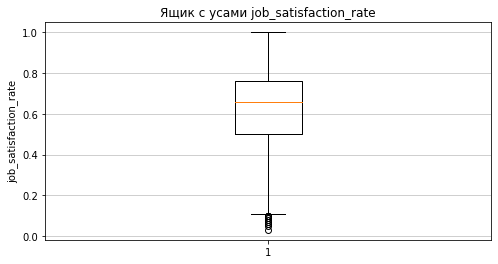

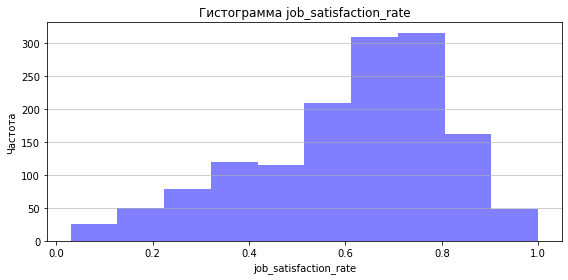

In [71]:
plot_numeric_features(df_test_target[df_test_target['quit'] == 'no'])

На графиках четко видно связь между уровнем удовлетворенности и вероятностью увольнения сотрудников. Средний уровень удовлетворенности (job_satisfaction_rate) среди оставшихся работников составляет 66%, и 75% из них демонстрируют уровень удовлетворенности не ниже 76%. В противоположность этому, средний уровень удовлетворенности у уволившихся сотрудников равен 37%, при этом 75% из них имеют уровень удовлетворенности, который не превышает 49%.

**Вывод**

1. Распределение количественных и качественных признаков соответствует таковому в предыдущей тренировочной выборке.
По признаку quit - 25.3% сотрудников уволились из компании

2. 75% уволенных сотрудников проработали в компании не более 3 лет и получали они не более 35000. Подавляющее большинство сотрудников работали на позиции junior. Процентное соотношение по оттоку кадров соответсвует их распределению в компании - из больших отделов sales и technology увольняется больше людей, чем из отделов по-меньше. Интересно, что преобладающее большинство (44,4%) уволившихся сотрудников имели низкую загруженность. 99,8% из них не получали повышения за последний год. Хотя в последнем случае имеет смысл учитывать, что большинство из них работали в компании непродолжительно.
3. В среднем оставшиеся сотрудники работают в компании около 5 лет. И зарплата 75% сотрудников больше 27000. Подавляющее большнство оставшихся сотрудников (78.2%) работают на позициях middle и senior. Низкая загруженность среди оставшихся сотрудников толко у 23.6%. 5.7% из оставшихся получили повышение за последний год
4. На графиках четко видно связь между уровнем удовлетворенности и вероятностью увольнения сотрудников. Средний уровень удовлетворенности (job_satisfaction_rate) среди оставшихся работников составляет 66%, и 75% из них демонстрируют уровень удовлетворенности не ниже 76%. В противоположность этому, средний уровень удовлетворенности у уволившихся сотрудников равен 37%, при этом 75% из них имеют уровень удовлетворенности, который не превышает 49%.

"Портрет" уволившегося сотрудника: Работает на позиции junior не более трех лет, получает меньше 35000. Имеет низкую загруженность. Не получал повышения за последний год.

## Добавление нового входного признака

Добавляю job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

In [72]:
df_train_quit['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(df_train_quit.drop(['quit'], axis=1))
df_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000.0,no,0.653333
814010,sales,junior,medium,2,no,no,4,27600.0,no,0.848750
155091,purchasing,middle,medium,5,no,no,1,37200.0,no,0.337500
257132,sales,junior,medium,2,no,yes,3,24000.0,yes,0.334286
910140,marketing,junior,medium,2,no,no,5,25200.0,no,0.791667


In [73]:
df_test_features['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(df_test_features)
df_test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200.0,0.828182
100480,marketing,junior,low,4,no,no,4,16800.0,0.852000
100503,purchasing,middle,high,5,no,no,4,55200.0,0.738000
100610,sales,middle,medium,5,no,no,4,43200.0,0.824643
100692,sales,middle,high,6,no,no,4,48000.0,0.702500


**Вывод**

Добавила job_satisfaction_rate к тренировочным и тестовым данным второй задачи

## Подготовка данных

Разделяю тренировочную выборку второй задачи на входные и целевой признаки:

In [74]:
X_train_2 = df_train_quit.drop(['quit'], axis=1)
y_train_2 = df_train_quit['quit']

X_test_2 = df_test_features
y_test_2 = df_test_target_quit['quit']

Кодирую целевой признак

In [75]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train_2)

y_train_2 = label_encoder.transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

Начинаю собирать пайплайн:

In [76]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate_pred']

In [77]:
# создаю пайплайн для подготовки признаков из списка ohe_columns:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

In [78]:
# cоздаю пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [
                             ['junior', 'middle', 'senior'],
                             ['low', 'medium', 'high']
                            ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [79]:
# создаю общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False
)

**Выводы**:

Объединила этапы подготовки данных, применяя пайплайны ohe_pipe и ord_pipe. В соответствии с условиями задачи использовала два кодировщика 

## Обучение модели

In [80]:
# создаю итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [81]:
param_rs = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 8), 
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
   
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression
        (
         random_state=RANDOM_STATE, 
            solver='liblinear',
            class_weight='balanced',
            penalty='l1'
        )
                  ],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    }
]

Наиболее подходящей метрикой для нашей задачи является roc-auc

In [82]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_rs, 
    scoring = 'roc_auc',
    cv=5,
    n_iter=20,
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
randomized_search_2.fit(X_train_2, y_train_2) 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations'])...
                                         'models__n_neighbors': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [83]:
print('Метрика ROC_AUC для лучшей модели:\n', randomized_search_2.best_score_)
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_) 

Метрика ROC_AUC для лучшей модели:
 0.9016046876489916
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
        

In [84]:
y_test_pred_2 = randomized_search_2.predict_proba(X_test_2)
#отбор 2 столбца, с вероятностью принадлежности к классу 1
y_test_pred_one = y_test_pred_2[:, 1]
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test_2, y_test_pred_one))

Метрика ROC-AUC на тестовой выборке: 0.9132983662261207


In [85]:
# создаю экземпляр DummyClassifier
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train_2, y_train_2)

# предсказания на тестовых данных
y_test_pred_dummy = dummy_classifier.predict_proba(X_test_2)[:, 1]

# оценка DummyClassfier с использованием метрики ROC_AUC
dummy_roc_auc = roc_auc_score(y_test_2, y_test_pred_dummy)

print('Метрика ROC_AUC для DummyClassifier:', dummy_roc_auc)

# сравнение результатов
if randomized_search_2.best_score_ < dummy_roc_auc:
    print('Лучшая модель не показывает улучшения по сравнению с DummyClassifier. Возможно, стоит пересмотреть подход.')
else:
    print('Лучшая модель значительно превосходит DummyClassifier по метрике ROC_AUC.')

Метрика ROC_AUC для DummyClassifier: 0.5
Лучшая модель значительно превосходит DummyClassifier по метрике ROC_AUC.


Убираю dept из  категориальных признаков

## **Вывод**

Наилучшей моделью в результате подбора оказалась модель KNeighborsClassifier(n_neighbors=14). Метрика roc_auc на тестовой выборке составила 91,3%. Лучшая модель значительно превосходит константную (DummyClassifier) по метрике ROC_AUC.

## Выводы

Во второй части работы было необходимо создать модель, которая позволит прогнозировать вероятность увольнения сотрудников из компании с целью оценки и предотвращения оттока кадров.

Работа состояла из нескольких этапов:
1. Анализ информации о данных: 
- В данных df_train_quit 4000 строк. Пропусков не обнаружено. Типы столбцов указаны верно. Названия столбцов корректны
- В данных df_test_target_quit 2000 строк. Пропусков не обнаружено. Типы столбцов указаны верно. Названия столбцов корректны.
2. Предобработка данных: 
- Во всех таблицах индексы заменены на id
- В столбце 'level' значение 'sinior' заменено на 'senior'
- Тип данных в столбце salary изменен на float64
- В df_train_quit удалены явные дубликаты
3. Исследовательский анализ данных:
- Распределение количественных и качественных признаков соответствует таковому в предыдущей тренировочной выборке. По признаку quit - 25.3% сотрудников уволились из компании

- 75% уволенных сотрудников проработали в компании не более 3 лет и получали они не более 35000. Подавляющее большинство сотрудников работали на позиции junior. Процентное соотношение по оттоку кадров соответсвует их распределению в компании - из больших отделов sales и technology увольняется больше людей, чем из отделов по-меньше. Интересно, что преобладающее большинство (44,4%) уволившихся сотрудников имели низкую загруженность. 99,8% из них не получали повышения за последний год. Хотя в последнем случае имеет смысл учитывать, что большинство из них работали в компании непродолжительно.

- В среднем оставшиеся сотрудники работают в компании около 5 лет. И зарплата 75% сотрудников больше 27000. Подавляющее большнство оставшихся сотрудников (78.2%) работают на позициях middle и senior. Низкая загруженность среди оставшихся сотрудников толко у 23.6%. 5.7% из оставшихся получили повышение за последний год

- На графиках четко видно связь между уровнем удовлетворенности и вероятностью увольнения сотрудников. Средний уровень удовлетворенности (job_satisfaction_rate) среди оставшихся работников составляет 66%, и 75% из них демонстрируют уровень удовлетворенности не ниже 76%. В противоположность этому, средний уровень удовлетворенности у уволившихся сотрудников равен 37%, при этом 75% из них имеют уровень удовлетворенности, который не превышает 49%.

- "Портрет" уволившегося сотрудника: Работает на позиции junior не более трех лет, получает меньше 35000. Имеет низкую загруженность. Не получал повышения за последний год.
4. Добавление нового входного признака
- Добавлен признак job_satisfaction_rate к тренировочным и тестовым данным второй задачи
5. Подготовка данных
- Объединены этапы подготовки данных, с применением пайплайнов ohe_pipe и ord_pipe. В соответствии с условиями задачи использованы два кодировщика
6. Обучение модели
- Наилучшей моделью в результате подбора оказалась модель KNeighborsClassifier(n_neighbors=14). Метрика roc_auc на тестовой выборке составила 91,3%

# Общий вывод 

В этой работе было необходимо помочь HR-аналитикам компании «Работа с заботой» в оптимизации управления персоналом. Для достижения этой цели были выполнены две основные задачи.

Первая задача заключалась в построении модели для предсказания уровня удовлетворённости сотрудников на основании предоставленных данных. Было обучено две модели: дерево решений и линейная регрессия, с применением методов масштабирования в качестве гиперпараметров. Для автоматического подбора гиперпараметров использовался инструмент RandomizedSearchCV. В качестве метрики оценки работы модели мы выбрали SMAPE (симметричное среднее абсолютное процентное отклонение). В результате оптимизации наилучшей моделью стала DecisionTreeRegressor с параметрами: criterion='friedman_mse', max_depth=14, max_features=9, min_samples_leaf=3 и min_samples_split=9. Значение метрики SMAPE на тестовой выборке составило 14,09%. 

Вторая задача заключалась в предсказании отток сотрудников за счет построения модели, прогнозирующей увольнение сотрудников из компании. Она была решена путем обучения трёх моделей: дерева решений, метода ближайших соседей и логистической регрессии. Наилучшей моделью в результате подбора оказалась модель KNeighborsClassifier(n_neighbors=14). Метрика roc_auc на тестовой выборке составила 91,3%

На основании нашего исследовательского анализа данных выделяется предложение для бизнеса: за последний год был зафиксирован крайне низкий процент повышений сотрудников, составляющий всего 3%, а также высокая доля работников начального уровня с низкими зарплатами, что привело к значительной текучке кадров среди этой категории. Для повышения мотивации и уровня удовлетворённости сотрудников в компании целесообразно разработать систему обучения, которая могла бы стимулировать карьерный рост, увеличивать зоны ответственности и зарплаты для сотрудников уровня junior, а также создавать больше возможностей для продвижения по службе.

